# 🏆 UIDAI Data Hackathon 2026 - Aadhaar Demographic Analysis

## Objective
Unlock meaningful patterns, trends, anomalies, and predictive indicators from Aadhaar Demographic data to support informed decision-making and system improvements.

## Analysis Scope
This notebook provides comprehensive exploratory data analysis (EDA) of:
- **2+ Million demographic records** across multiple states and districts
- **Temporal patterns**: Daily, weekly, and monthly trends
- **Geographic distribution**: State, district, and PIN code level insights
- **Age group analysis**: Demographic patterns by age groups
- **Performance metrics**: Efficiency, utilization, and inequality measures
- **Operational insights**: Weekend operations, campaigns, and infrastructure gaps

## Key Analysis Sections
1. **Data Loading & Quality Assessment**
2. **Feature Engineering & Data Preparation**
3. **Descriptive Statistics & Geographic Analysis**
4. **Time-Based Trend Analysis**
5. **Growth Rate & Momentum Analysis**
6. **Seasonal Pattern Decomposition**
7. **Correlation & Statistical Testing**
8. **State & District Performance Rankings**
9. **Efficiency & Capacity Metrics**
10. **Advanced Visualizations**
11. **Key Insights & Recommendations**

## 📚 Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure matplotlib to handle Unicode properly
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 📂 Data Loading

In [17]:
files = [
    "../data/api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv",
    "../data/api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv",
    "../data/api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv",
    "../data/api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv",
    "../data/api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv",
]

print("Loading demographic data files...")
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

print(f"\n✅ Loaded {len(df):,} records")
print(f"\nSample data:")
print(df.sample(5))
print(f"\nDataset Info:")
df.info()

Loading demographic data files...

✅ Loaded 2,071,700 records

Sample data:
               date        state   district  pincode  demo_age_5_17  demo_age_17_
527350   26-10-2025        Bihar  Begusarai   851135              1             9
387154   25-12-2025    Karnataka    Belgaum   591217              2             3
371726   21-12-2025  Maharashtra     Nanded   431801              3             6
1416673  02-11-2025       Odisha  Kandhamal   762022              1             0
32153    08-09-2025    Jharkhand    Latehar   822126              7            76

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB


## 🔧 Data Preprocessing & Feature Engineering

In [18]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# State name standardization function
def standardize_state_name(state):
    state_mapping = {
        'andaman & nicobar island': 'Andaman and Nicobar Islands',
        'andaman and nicobar island': 'Andaman and Nicobar Islands',
        'andaman & nicobar islands': 'Andaman and Nicobar Islands',
        'andhra pradesh': 'Andhra Pradesh',
        'arunachal pradesh': 'Arunachal Pradesh',
        'assam': 'Assam',
        'bihar': 'Bihar',
        'chandigarh': 'Chandigarh',
        'chhattisgarh': 'Chhattisgarh',
        'dadra & nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
        'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
        'daman & diu': 'Dadra and Nagar Haveli and Daman and Diu',
        'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
        'delhi': 'Delhi',
        'goa': 'Goa',
        'gujarat': 'Gujarat',
        'haryana': 'Haryana',
        'himachal pradesh': 'Himachal Pradesh',
        'jammu & kashmir': 'Jammu and Kashmir',
        'jammu and kashmir': 'Jammu and Kashmir',
        'jharkhand': 'Jharkhand',
        'karnataka': 'Karnataka',
        'kerala': 'Kerala',
        'ladakh': 'Ladakh',
        'lakshadweep': 'Lakshadweep',
        'madhya pradesh': 'Madhya Pradesh',
        'maharashtra': 'Maharashtra',
        'manipur': 'Manipur',
        'meghalaya': 'Meghalaya',
        'mizoram': 'Mizoram',
        'nagaland': 'Nagaland',
        'odisha': 'Odisha',
        'puducherry': 'Puducherry',
        'punjab': 'Punjab',
        'rajasthan': 'Rajasthan',
        'sikkim': 'Sikkim',
        'tamil nadu': 'Tamil Nadu',
        'telangana': 'Telangana',
        'tripura': 'Tripura',
        'uttar pradesh': 'Uttar Pradesh',
        'uttarakhand': 'Uttarakhand',
        'west bengal': 'West Bengal'
    }
    if pd.isna(state):
        return state
    return state_mapping.get(state.lower(), state)

# District name standardization
def standardize_district_name(district):
    if pd.isna(district):
        return district
    return district.strip().title()

# Apply standardization
df['state'] = df['state'].apply(standardize_state_name)
df['district'] = df['district'].apply(standardize_district_name)

# Create calculated columns
df['total_demographics'] = df['demo_age_5_17'] + df['demo_age_17_']
df['demo_age_ratio'] = (df['demo_age_5_17'] / df['demo_age_17_']).replace([np.inf, -np.inf], np.nan)

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("✅ Data preprocessing complete!\\n")
print(f"Date range: {df['date'].min().strftime('%d-%m-%Y')} to {df['date'].max().strftime('%d-%m-%Y')}")
print(f"Total records: {len(df):,}")
print(f"States: {df['state'].nunique()}")
print(f"Districts: {df['district'].nunique()}")
print(f"PIN Codes: {df['pincode'].nunique()}")
print(f"\\nNew columns added: total_demographics, demo_age_ratio, year, month, day, day_of_week, week, is_weekend")

✅ Data preprocessing complete!\n
Date range: 01-03-2025 to 29-12-2025
Total records: 2,071,700
States: 53
Districts: 961
PIN Codes: 19742
\nNew columns added: total_demographics, demo_age_ratio, year, month, day, day_of_week, week, is_weekend


## 📊 Descriptive Statistics

In [19]:
print("=" * 100)
print("DESCRIPTIVE STATISTICS - DEMOGRAPHIC DATA")
print("=" * 100)

# Overall statistics
print("\n📈 OVERALL STATISTICS:")
print(df[['demo_age_5_17', 'demo_age_17_', 'total_demographics', 'demo_age_ratio']].describe())

# Age group statistics
print("\n\n👥 AGE GROUP BREAKDOWN:")
print(f"Total Demo Age 5-17: {df['demo_age_5_17'].sum():,}")
print(f"Total Demo Age 17+: {df['demo_age_17_'].sum():,}")
print(f"Grand Total: {df['total_demographics'].sum():,}")
print(f"Average Age 5-17 per record: {df['demo_age_5_17'].mean():.2f}")
print(f"Average Age 17+ per record: {df['demo_age_17_'].mean():.2f}")
print(f"Average Total per record: {df['total_demographics'].mean():.2f}")

# Weekend vs Weekday
weekend_stats = df.groupby('is_weekend').agg({
    'total_demographics': ['sum', 'mean', 'count']
}).round(2)
weekend_stats.columns = ['Total', 'Mean', 'Count']
weekend_stats.index = ['Weekday', 'Weekend']
print("\n\n📅 WEEKEND vs WEEKDAY:")
print(weekend_stats)

DESCRIPTIVE STATISTICS - DEMOGRAPHIC DATA

📈 OVERALL STATISTICS:
       demo_age_5_17  demo_age_17_  total_demographics  demo_age_ratio
count   2.071700e+06  2.071700e+06        2.071700e+06    2.029890e+06
mean    2.347552e+00  2.144701e+01        2.379456e+01    1.457476e-01
std     1.490355e+01  1.252498e+02        1.381999e+02    3.003714e-01
min     0.000000e+00  0.000000e+00        0.000000e+00    0.000000e+00
25%     0.000000e+00  2.000000e+00        3.000000e+00    0.000000e+00
50%     1.000000e+00  6.000000e+00        7.000000e+00    2.631579e-02
75%     2.000000e+00  1.500000e+01        1.700000e+01    1.666667e-01
max     2.690000e+03  1.616600e+04        1.694200e+04    2.500000e+01


👥 AGE GROUP BREAKDOWN:
Total Demo Age 5-17: 4,863,424
Total Demo Age 17+: 44,431,763
Grand Total: 49,295,187
Average Age 5-17 per record: 2.35
Average Age 17+ per record: 21.45
Average Total per record: 23.79


📅 WEEKEND vs WEEKDAY:
            Total   Mean    Count
Weekday  29884064  19.35  1

## 🗺️ Geographic Analysis - State Level

STATE-LEVEL DEMOGRAPHIC STATISTICS
                Total_Demo  Mean_Demo  Std_Demo  Total_Age_5_17  Mean_Age_5_17  Total_Age_17_  Mean_Age_17_  Districts  PINcodes  Records
state                                                                                                                                    
Uttar Pradesh      8542328      50.88    242.35          790308           4.71        7752020         46.17         90      1760   167889
Maharashtra        5054602      31.15    109.45          273322           1.68        4781280         29.47         53      1609   162242
Bihar              4814350      49.32    145.72          380023           3.89        4434327         45.42         46       921    97621
West Bengal        3872318      22.95     93.71          242551           1.44        3629767         21.51         48      1364   168727
Madhya Pradesh     2912938      38.15    177.56          407098           5.33        2505840         32.81         60       796    76364

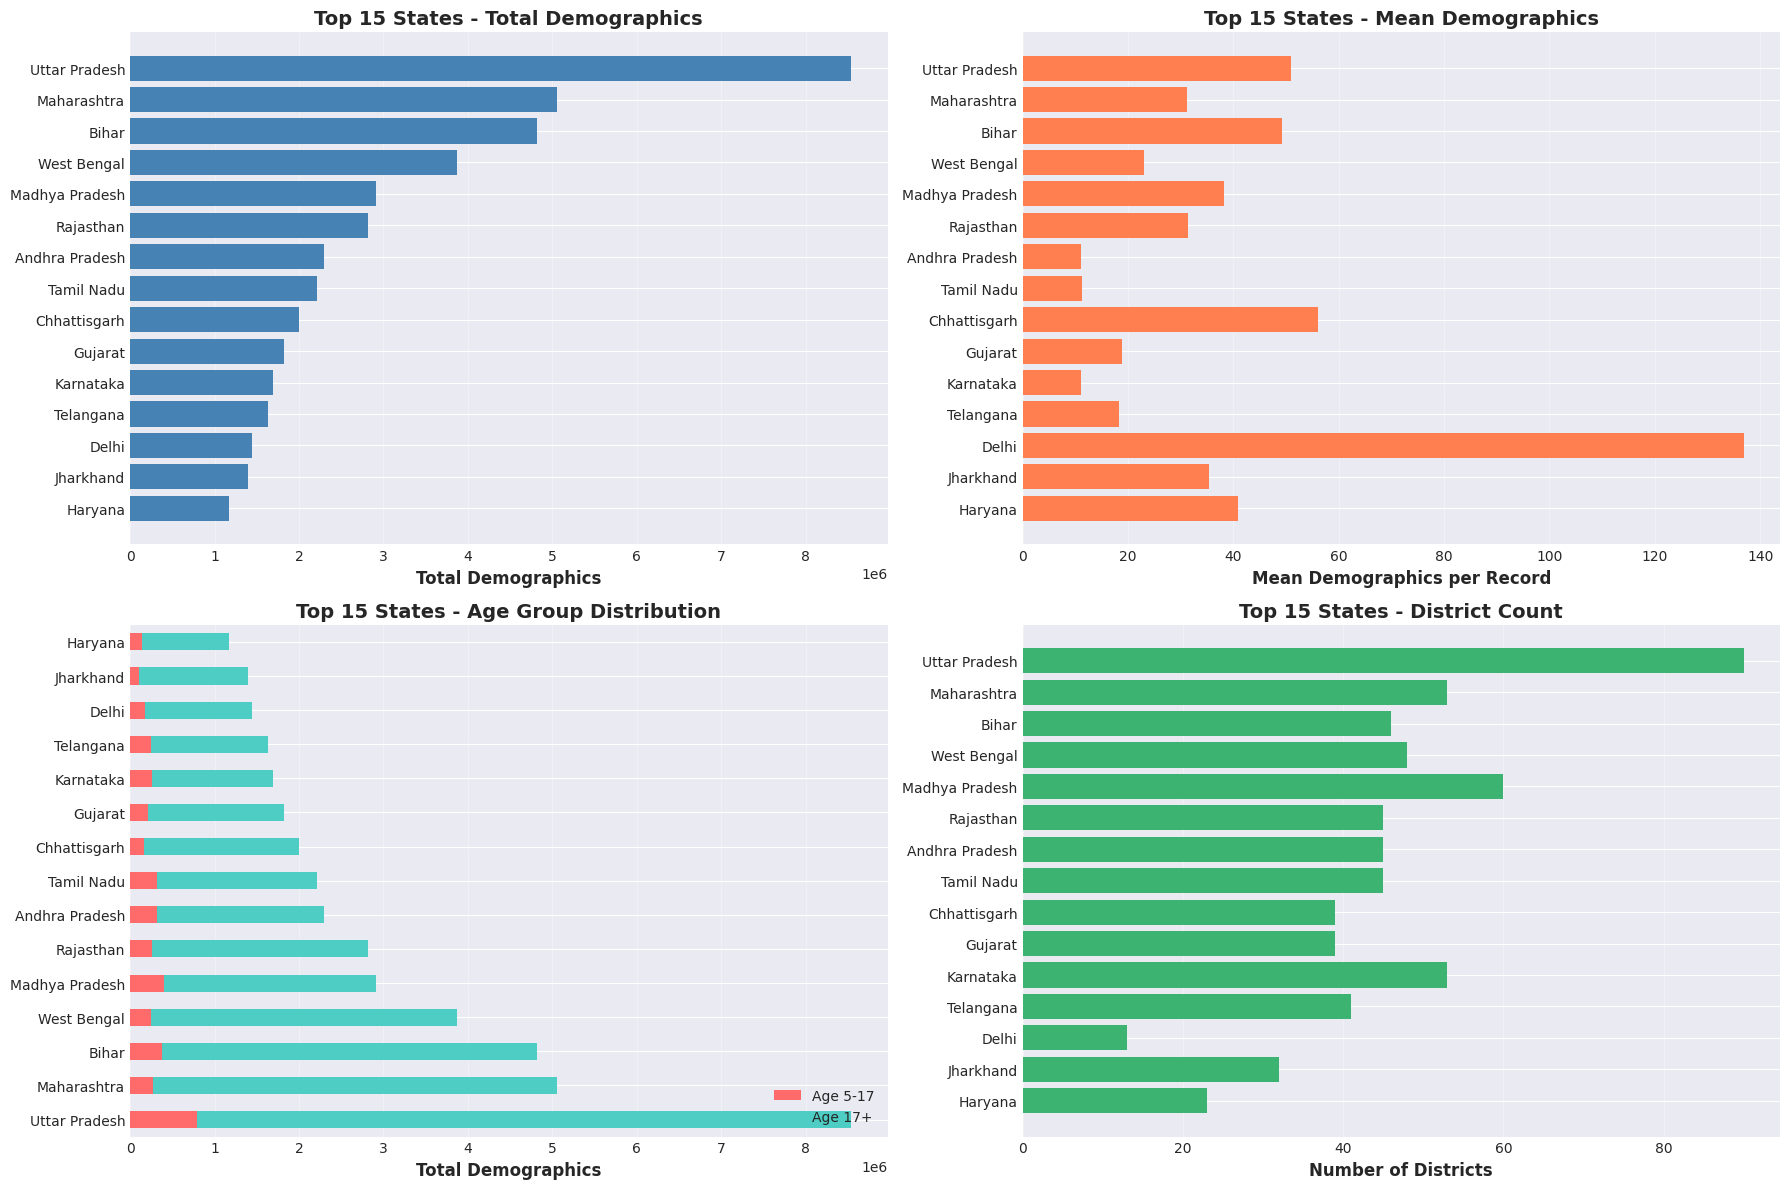

In [20]:
# State-level statistics
state_stats = df.groupby('state').agg({
    'total_demographics': ['sum', 'mean', 'std'],
    'demo_age_5_17': ['sum', 'mean'],
    'demo_age_17_': ['sum', 'mean'],
    'district': 'nunique',
    'pincode': 'nunique',
    'state': 'size'
}).round(2)

state_stats.columns = ['Total_Demo', 'Mean_Demo', 'Std_Demo', 'Total_Age_5_17', 'Mean_Age_5_17', 
                       'Total_Age_17_', 'Mean_Age_17_', 'Districts', 'PINcodes', 'Records']
state_stats = state_stats.sort_values('Total_Demo', ascending=False)

print("=" * 120)
print("STATE-LEVEL DEMOGRAPHIC STATISTICS")
print("=" * 120)
print(state_stats.head(15))
print("\n")

# Visualize top 15 states
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Total demographics by state
top_states = state_stats.head(15)
axes[0, 0].barh(range(len(top_states)), top_states['Total_Demo'], color='steelblue')
axes[0, 0].set_yticks(range(len(top_states)))
axes[0, 0].set_yticklabels(top_states.index, fontsize=10)
axes[0, 0].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Top 15 States - Total Demographics', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Mean demographics by state
axes[0, 1].barh(range(len(top_states)), top_states['Mean_Demo'], color='coral')
axes[0, 1].set_yticks(range(len(top_states)))
axes[0, 1].set_yticklabels(top_states.index, fontsize=10)
axes[0, 1].set_xlabel('Mean Demographics per Record', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Top 15 States - Mean Demographics', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Age group distribution
age_data = top_states[['Total_Age_5_17', 'Total_Age_17_']]
age_data.plot(kind='barh', stacked=True, ax=axes[1, 0], color=['#FF6B6B', '#4ECDC4'])
axes[1, 0].set_ylabel('')
axes[1, 0].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 15 States - Age Group Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(['Age 5-17', 'Age 17+'], loc='lower right')
axes[1, 0].grid(axis='x', alpha=0.3)

# Number of districts per state
axes[1, 1].barh(range(len(top_states)), top_states['Districts'], color='mediumseagreen')
axes[1, 1].set_yticks(range(len(top_states)))
axes[1, 1].set_yticklabels(top_states.index, fontsize=10)
axes[1, 1].set_xlabel('Number of Districts', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Top 15 States - District Count', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 🏘️ Geographic Analysis - District Level

TOP 20 DISTRICTS - DEMOGRAPHIC STATISTICS
                                 Total_Demo  Mean_Demo  Total_Age_5_17  Total_Age_17_  PINcodes
state         district                                                                         
Maharashtra   Thane                  447253      57.75           36090         411163        96
              Pune                   438478      35.22           32644         405834       152
West Bengal   South 24 Parganas      401187      50.27           27728         373459        95
              Murshidabad            371953      46.18           31110         340843       100
Gujarat       Surat                  357582      57.43           35198         322384        88
Delhi         North West Delhi       313989     192.51           39744         274245        18
Karnataka     Bengaluru              303924      31.09           38541         265383       128
West Bengal   North 24 Parganas      290477      22.35           15020         275457       15

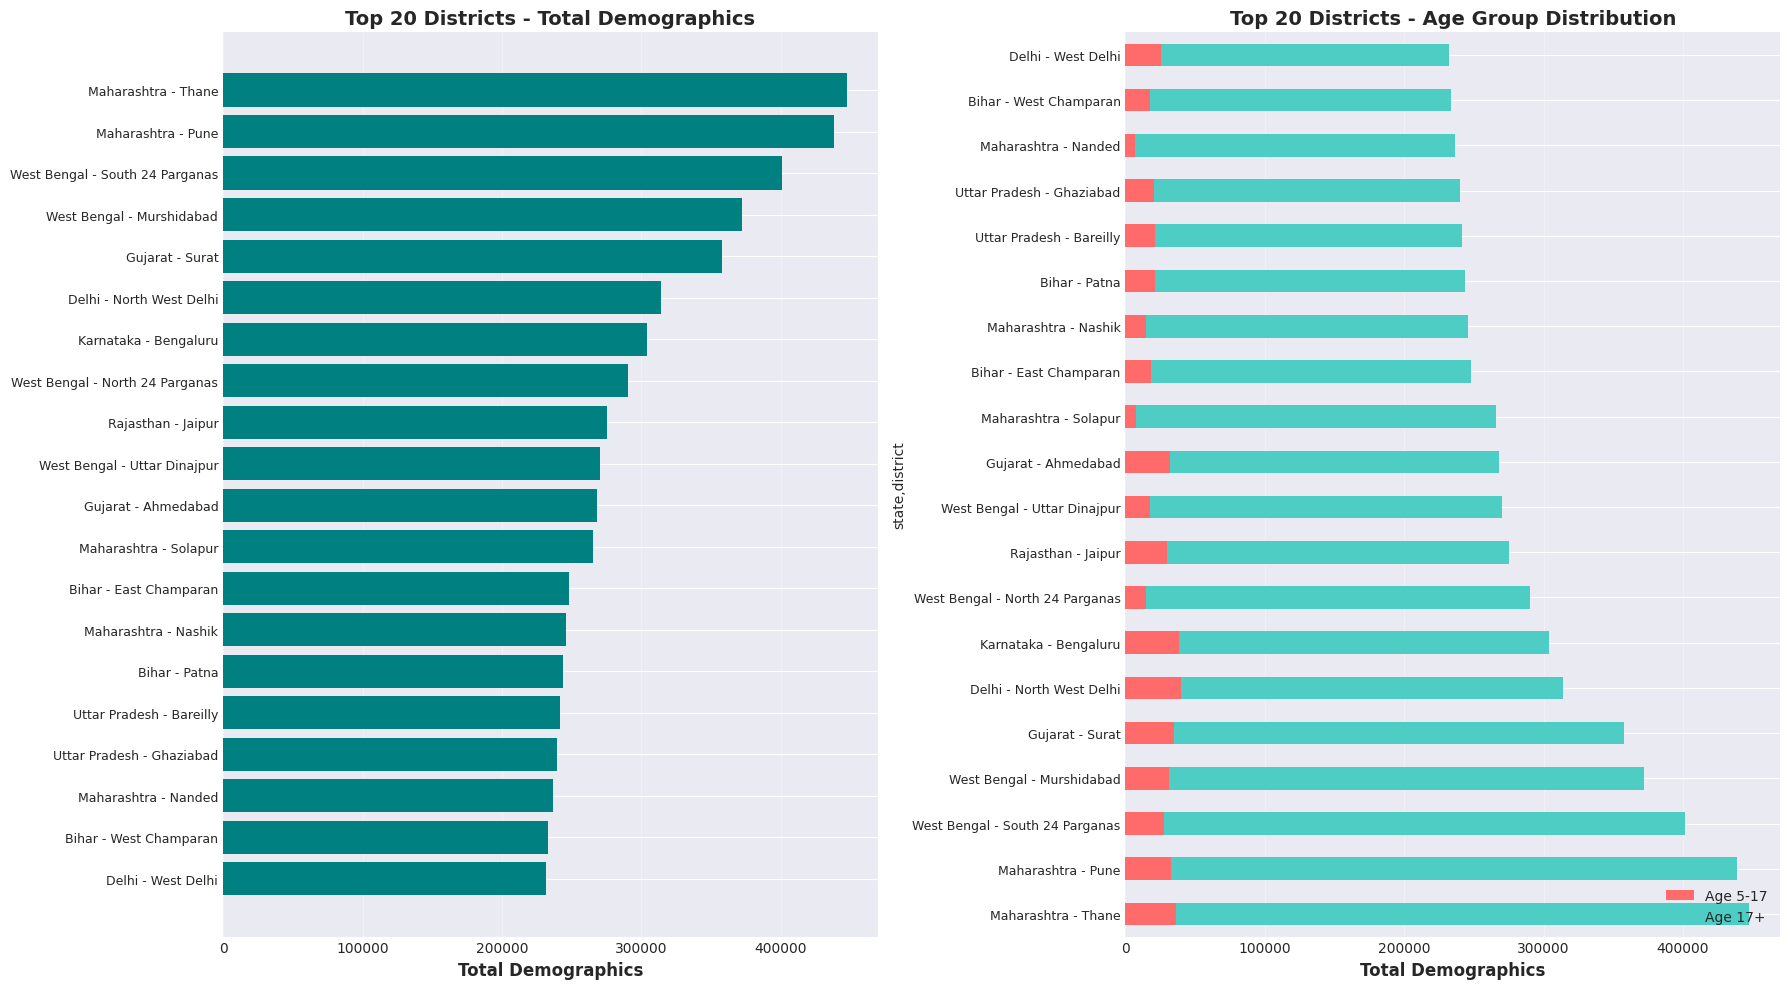

In [21]:
# District-level statistics
district_stats = df.groupby(['state', 'district']).agg({
    'total_demographics': ['sum', 'mean'],
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'pincode': 'nunique'
}).round(2)

district_stats.columns = ['Total_Demo', 'Mean_Demo', 'Total_Age_5_17', 'Total_Age_17_', 'PINcodes']
district_stats = district_stats.sort_values('Total_Demo', ascending=False)

print("=" * 100)
print("TOP 20 DISTRICTS - DEMOGRAPHIC STATISTICS")
print("=" * 100)
print(district_stats.head(20))

# Visualize top 20 districts
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

top_districts = district_stats.head(20)
district_labels = [f"{state} - {dist}" for state, dist in top_districts.index]

# Total demographics
axes[0].barh(range(len(top_districts)), top_districts['Total_Demo'], color='teal')
axes[0].set_yticks(range(len(top_districts)))
axes[0].set_yticklabels(district_labels, fontsize=9)
axes[0].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Districts - Total Demographics', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Age group stacked bar
age_data = top_districts[['Total_Age_5_17', 'Total_Age_17_']]
age_data.plot(kind='barh', stacked=True, ax=axes[1], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_yticks(range(len(top_districts)))
axes[1].set_yticklabels(district_labels, fontsize=9)
axes[1].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Districts - Age Group Distribution', fontsize=14, fontweight='bold')
axes[1].legend(['Age 5-17', 'Age 17+'], loc='lower right')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 📍 Geographic Analysis - PIN Code Level

TOP 20 PIN CODES - DEMOGRAPHIC STATISTICS
         Total_Demo  Mean_Demo  Total_Age_5_17  Total_Age_17_          State          District
pincode                                                                                       
110059       115643    1180.03           11402         104241          Delhi        West Delhi
110094       103473     353.15           18284          85189          Delhi  North East Delhi
244001        97294    1013.48            8255          89039  Uttar Pradesh         Moradabad
283203        88415     911.49            6753          81662  Uttar Pradesh         Firozabad
202001        81890     538.75            6009          75881  Uttar Pradesh           Aligarh
244901        75924     782.72            5784          70140  Uttar Pradesh            Rampur
247001        75870     798.63            6098          69772  Uttar Pradesh        Saharanpur
121004        66997     343.57            8934          58063        Haryana         Faridabad
110092  

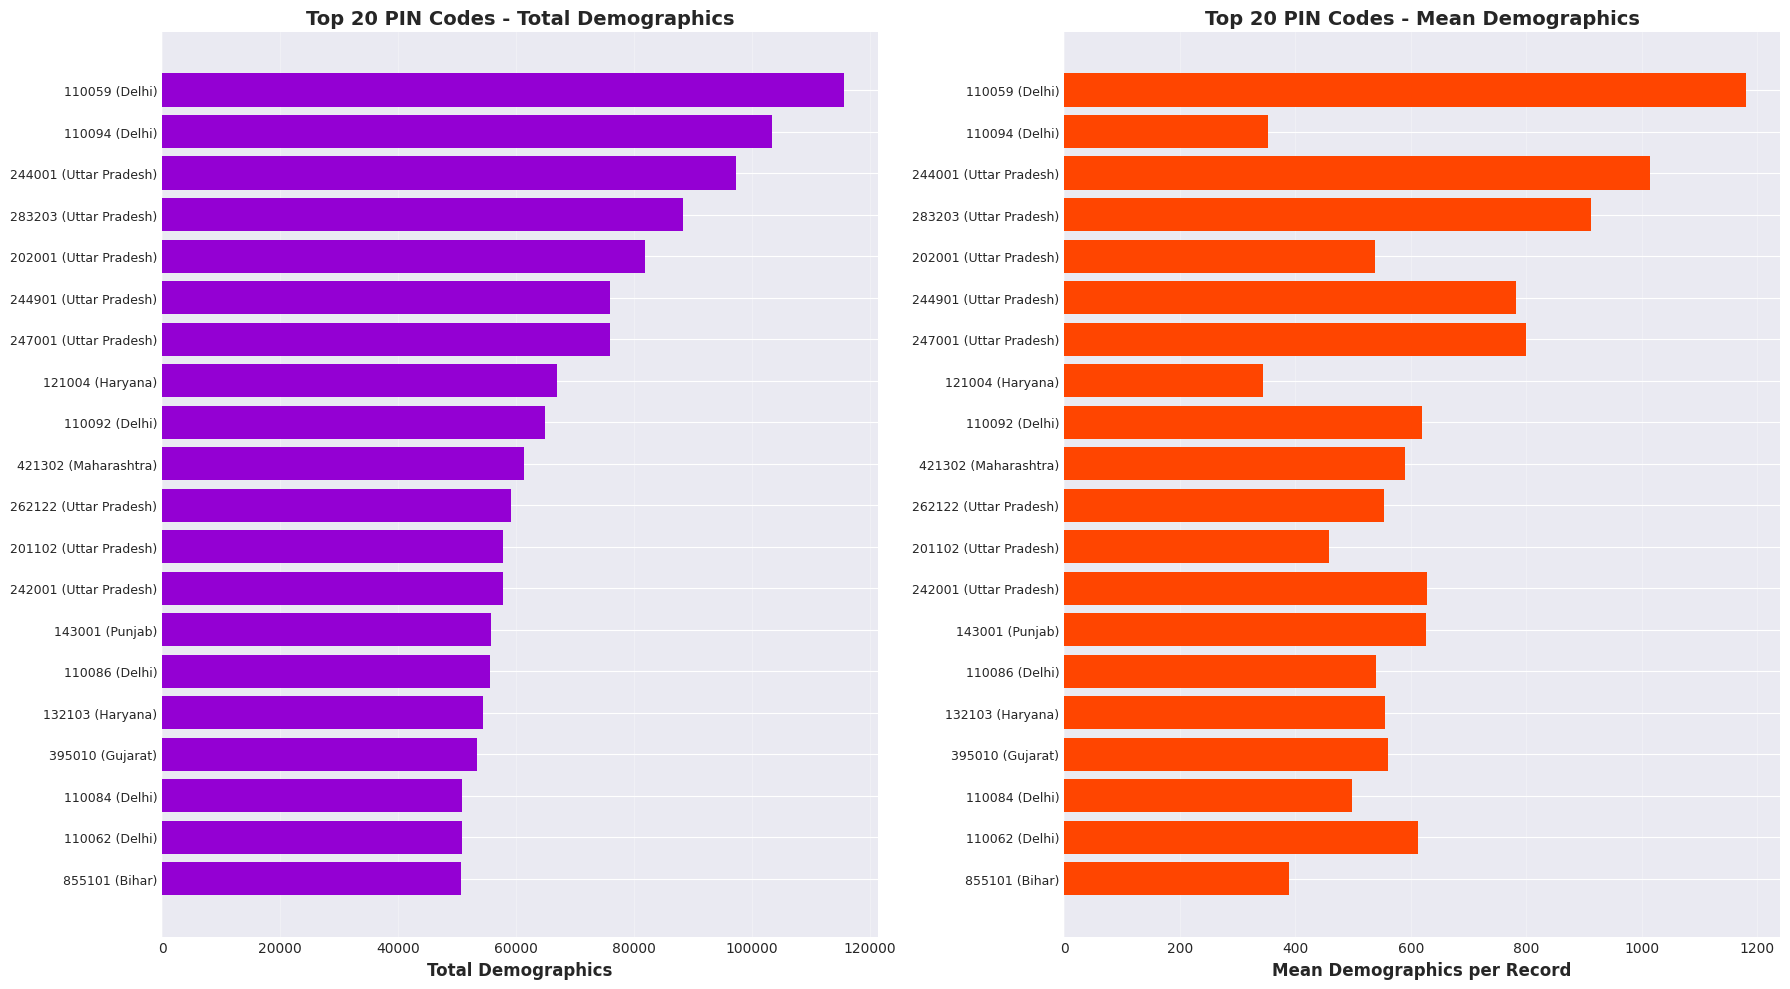

In [22]:
# PIN code-level statistics
pincode_stats = df.groupby('pincode').agg({
    'total_demographics': ['sum', 'mean'],
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'state': 'first',
    'district': 'first'
}).round(2)

pincode_stats.columns = ['Total_Demo', 'Mean_Demo', 'Total_Age_5_17', 'Total_Age_17_', 'State', 'District']
pincode_stats = pincode_stats.sort_values('Total_Demo', ascending=False)

print("=" * 100)
print("TOP 20 PIN CODES - DEMOGRAPHIC STATISTICS")
print("=" * 100)
print(pincode_stats.head(20))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

top_pins = pincode_stats.head(20)
pin_labels = [f"{pin} ({state})" for pin, state in zip(top_pins.index, top_pins['State'])]

# Total demographics
axes[0].barh(range(len(top_pins)), top_pins['Total_Demo'], color='darkviolet')
axes[0].set_yticks(range(len(top_pins)))
axes[0].set_yticklabels(pin_labels, fontsize=9)
axes[0].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 PIN Codes - Total Demographics', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Mean demographics per record
axes[1].barh(range(len(top_pins)), top_pins['Mean_Demo'], color='orangered')
axes[1].set_yticks(range(len(top_pins)))
axes[1].set_yticklabels(pin_labels, fontsize=9)
axes[1].set_xlabel('Mean Demographics per Record', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 PIN Codes - Mean Demographics', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## ⏰ Temporal Analysis - Daily Trends

DAILY TIME SERIES STATISTICS
                                date  demo_age_5_17  demo_age_17_  total_demographics
count                             95      95.000000  9.500000e+01        9.500000e+01
mean   2025-10-25 18:56:50.526315776   51193.936842  4.677028e+05        5.188967e+05
min              2025-03-01 00:00:00    1719.000000  8.729000e+03        1.044800e+04
25%              2025-09-19 12:00:00   26169.500000  2.261075e+05        2.565460e+05
50%              2025-11-05 00:00:00   34984.000000  3.317030e+05        3.670050e+05
75%              2025-12-04 12:00:00   44696.000000  4.260295e+05        4.677180e+05
max              2025-12-29 00:00:00  976095.000000  1.017146e+07        1.114756e+07
std                              NaN  104294.125915  1.044707e+06        1.147893e+06


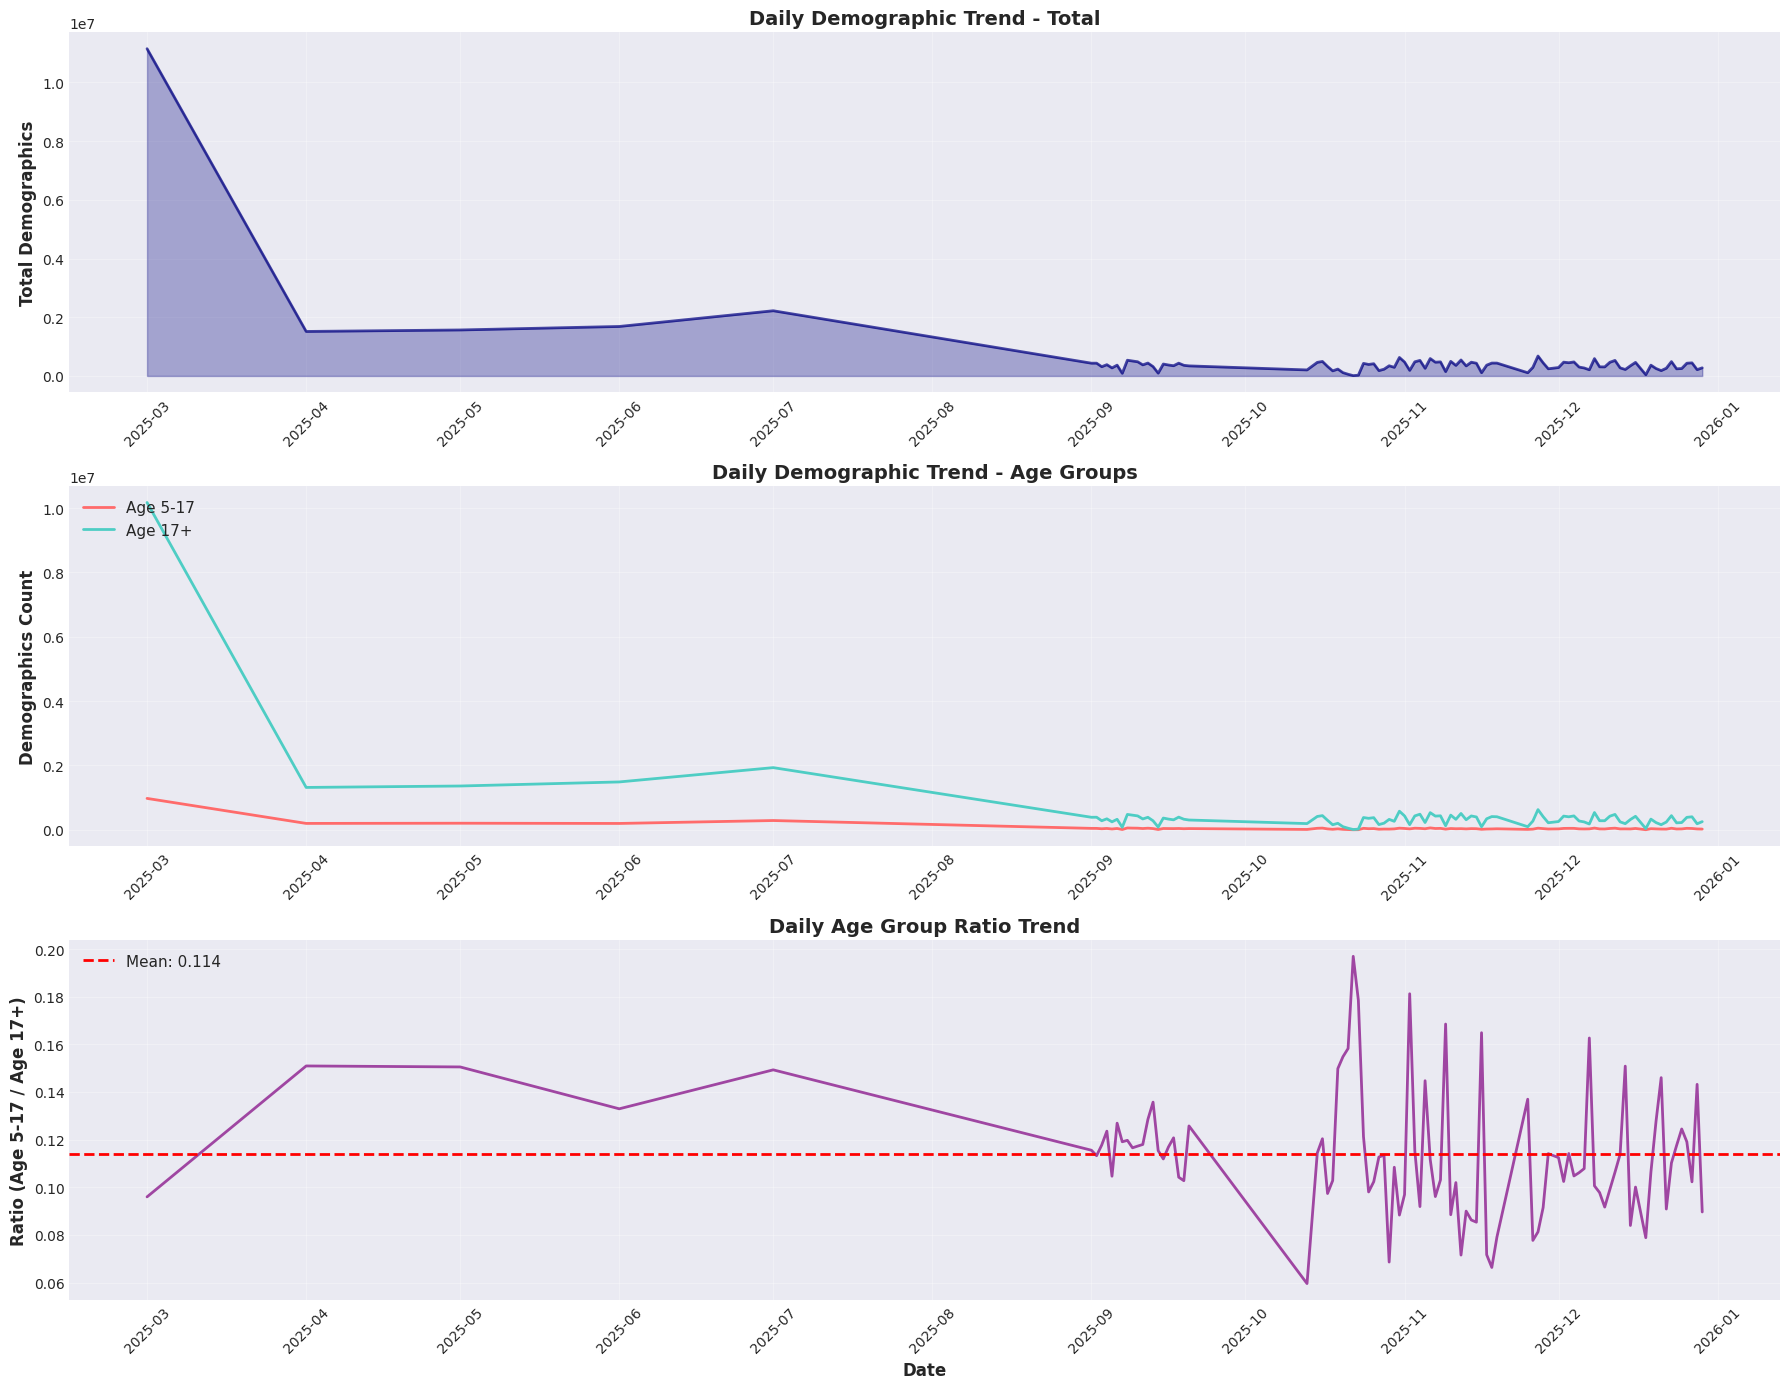

In [23]:
# Daily time series for age groups
daily_age_ts = df.groupby('date').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_demographics': 'sum'
}).reset_index()

print("=" * 80)
print("DAILY TIME SERIES STATISTICS")
print("=" * 80)
print(daily_age_ts.describe())

# Plot daily trends
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# Total demographics over time
axes[0].plot(daily_age_ts['date'], daily_age_ts['total_demographics'], linewidth=2, color='navy', alpha=0.7)
axes[0].fill_between(daily_age_ts['date'], daily_age_ts['total_demographics'], alpha=0.3, color='navy')
axes[0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0].set_title('Daily Demographic Trend - Total', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Age group comparison
axes[1].plot(daily_age_ts['date'], daily_age_ts['demo_age_5_17'], linewidth=2, label='Age 5-17', color='#FF6B6B')
axes[1].plot(daily_age_ts['date'], daily_age_ts['demo_age_17_'], linewidth=2, label='Age 17+', color='#4ECDC4')
axes[1].set_ylabel('Demographics Count', fontsize=12, fontweight='bold')
axes[1].set_title('Daily Demographic Trend - Age Groups', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Age group ratio over time
daily_age_ts['ratio'] = daily_age_ts['demo_age_5_17'] / daily_age_ts['demo_age_17_']
axes[2].plot(daily_age_ts['date'], daily_age_ts['ratio'], linewidth=2, color='purple', alpha=0.7)
axes[2].axhline(y=daily_age_ts['ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {daily_age_ts["ratio"].mean():.3f}')
axes[2].set_ylabel('Ratio (Age 5-17 / Age 17+)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].set_title('Daily Age Group Ratio Trend', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 📅 Temporal Analysis - Weekly & Monthly Patterns

WEEKLY PATTERN ANALYSIS
              Total   Mean     Std
Monday      4982642  15.50   28.43
Tuesday     8506008  27.88  199.99
Wednesday   4499616  16.03   30.56
Thursday    6424767  20.92  111.95
Friday      5471031  16.58   29.52
Saturday   15618092  49.43  226.98
Sunday      3793031  17.95  170.62

MONTHLY PATTERN ANALYSIS
        Total     Mean      Std  Age_5_17   Age_17_
Mar  11147558   605.25   737.42    976095  10171463
Apr   1515672  1374.14  1634.15    198744   1316928
May   1566287  1139.95  1163.36    204893   1361394
Jun   1685562  1509.01  1791.72    197767   1487795
Jul   2220715  1613.89  1592.17    288449   1932266
Sep   7324060    16.28    29.53    770788   6553272
Oct   5010966    13.39    25.41    479232   4531734
Nov   9387601    16.56    33.21    821273   8566328
Dec   9436766    14.35    23.96    926183   8510583


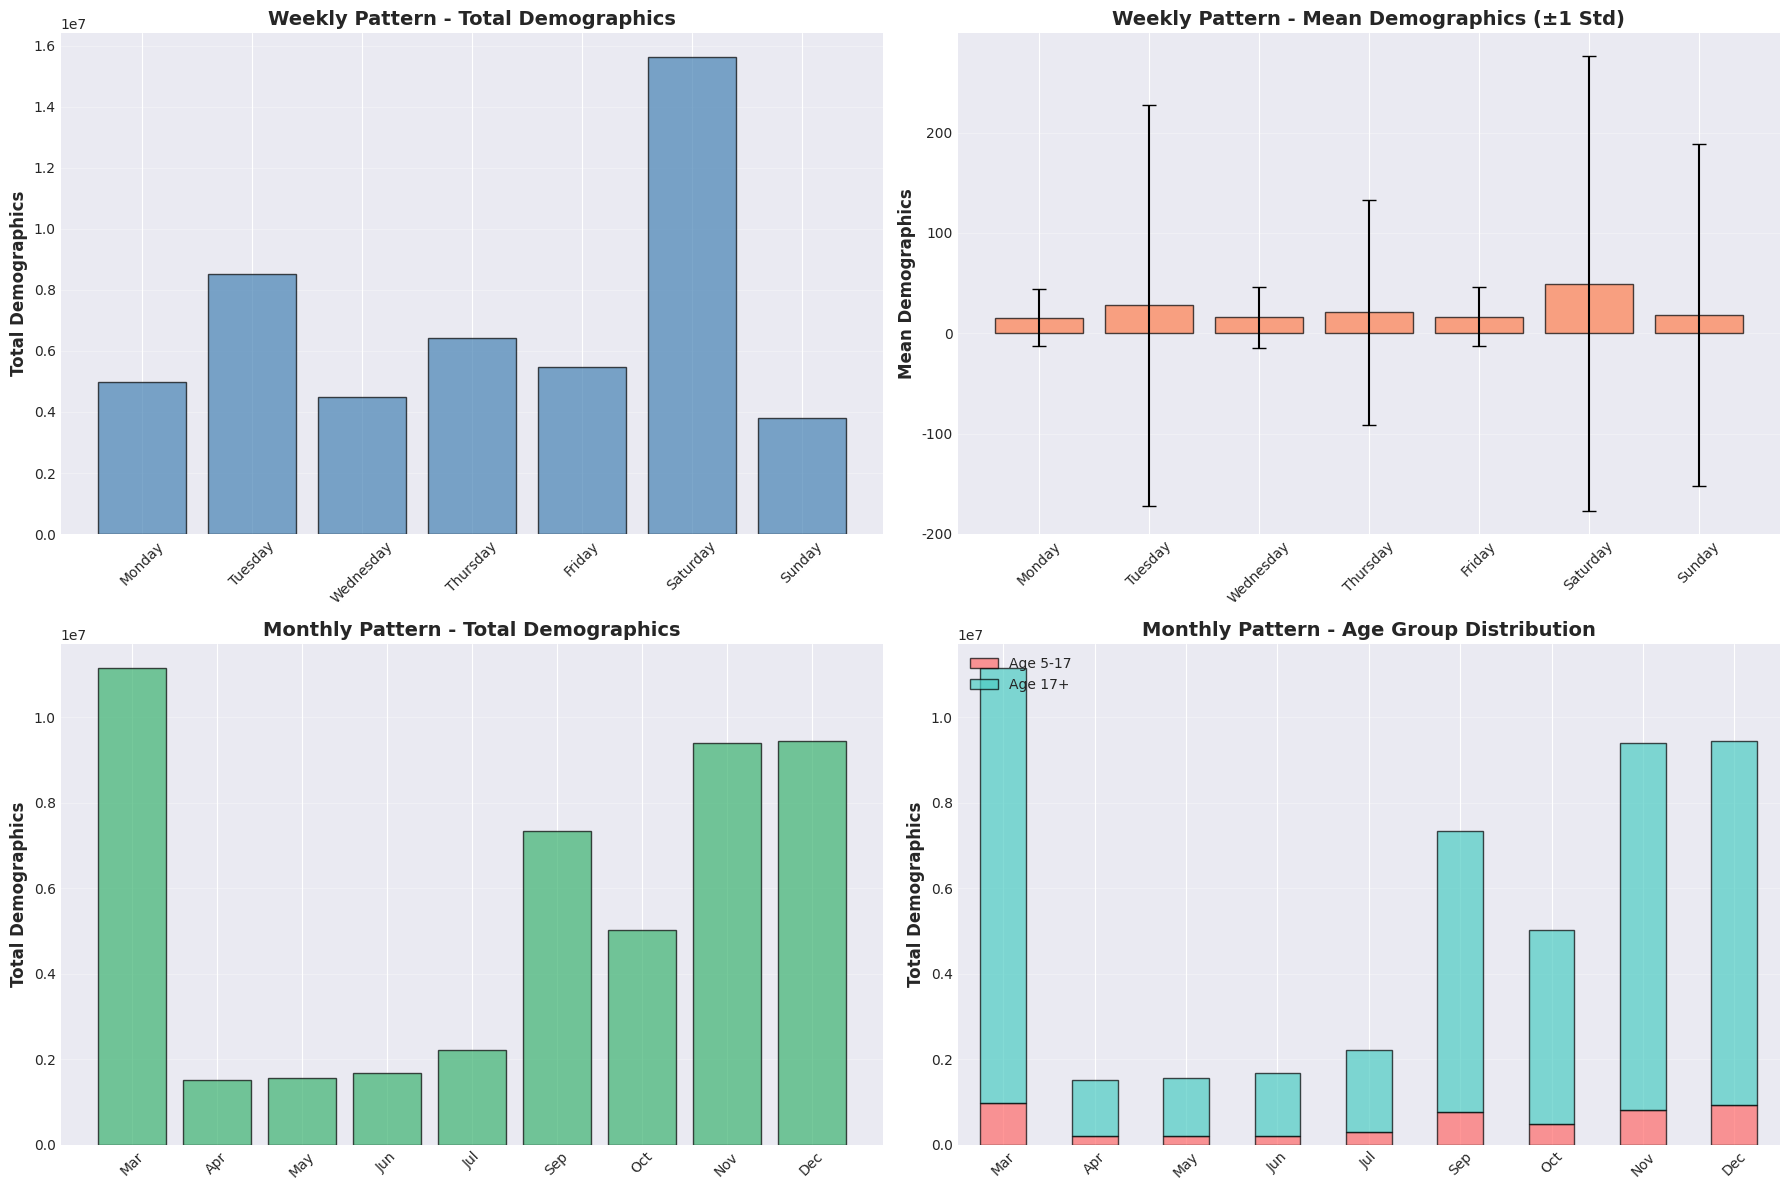

In [24]:
# Weekly pattern
weekly_pattern = df.groupby('day_of_week').agg({
    'total_demographics': ['sum', 'mean', 'std']
}).round(2)
weekly_pattern.columns = ['Total', 'Mean', 'Std']
weekly_pattern.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("=" * 80)
print("WEEKLY PATTERN ANALYSIS")
print("=" * 80)
print(weekly_pattern)

# Monthly pattern
monthly_demo_pattern = df.groupby('month').agg({
    'total_demographics': ['sum', 'mean', 'std'],
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).round(2)
monthly_demo_pattern.columns = ['Total', 'Mean', 'Std', 'Age_5_17', 'Age_17_']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_demo_pattern.index = [month_names[i-1] for i in monthly_demo_pattern.index]

print("\n" + "=" * 80)
print("MONTHLY PATTERN ANALYSIS")
print("=" * 80)
print(monthly_demo_pattern)

# Visualize patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Weekly bar chart
axes[0, 0].bar(weekly_pattern.index, weekly_pattern['Total'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Weekly Pattern - Total Demographics', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Weekly mean with error bars
axes[0, 1].bar(weekly_pattern.index, weekly_pattern['Mean'], yerr=weekly_pattern['Std'], 
               color='coral', alpha=0.7, edgecolor='black', capsize=5)
axes[0, 1].set_ylabel('Mean Demographics', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Weekly Pattern - Mean Demographics (±1 Std)', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Monthly bar chart
axes[1, 0].bar(monthly_demo_pattern.index, monthly_demo_pattern['Total'], color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Monthly Pattern - Total Demographics', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Monthly age group stacked bar
monthly_demo_pattern[['Age_5_17', 'Age_17_']].plot(kind='bar', stacked=True, ax=axes[1, 1], 
                                                     color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Monthly Pattern - Age Group Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].legend(['Age 5-17', 'Age 17+'], loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 Advanced Visualization 1: Distribution Analysis with Box Plots and KDE

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5632\3474517009.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df_top10[df_top10['state'] == state]['total_demographics'].values


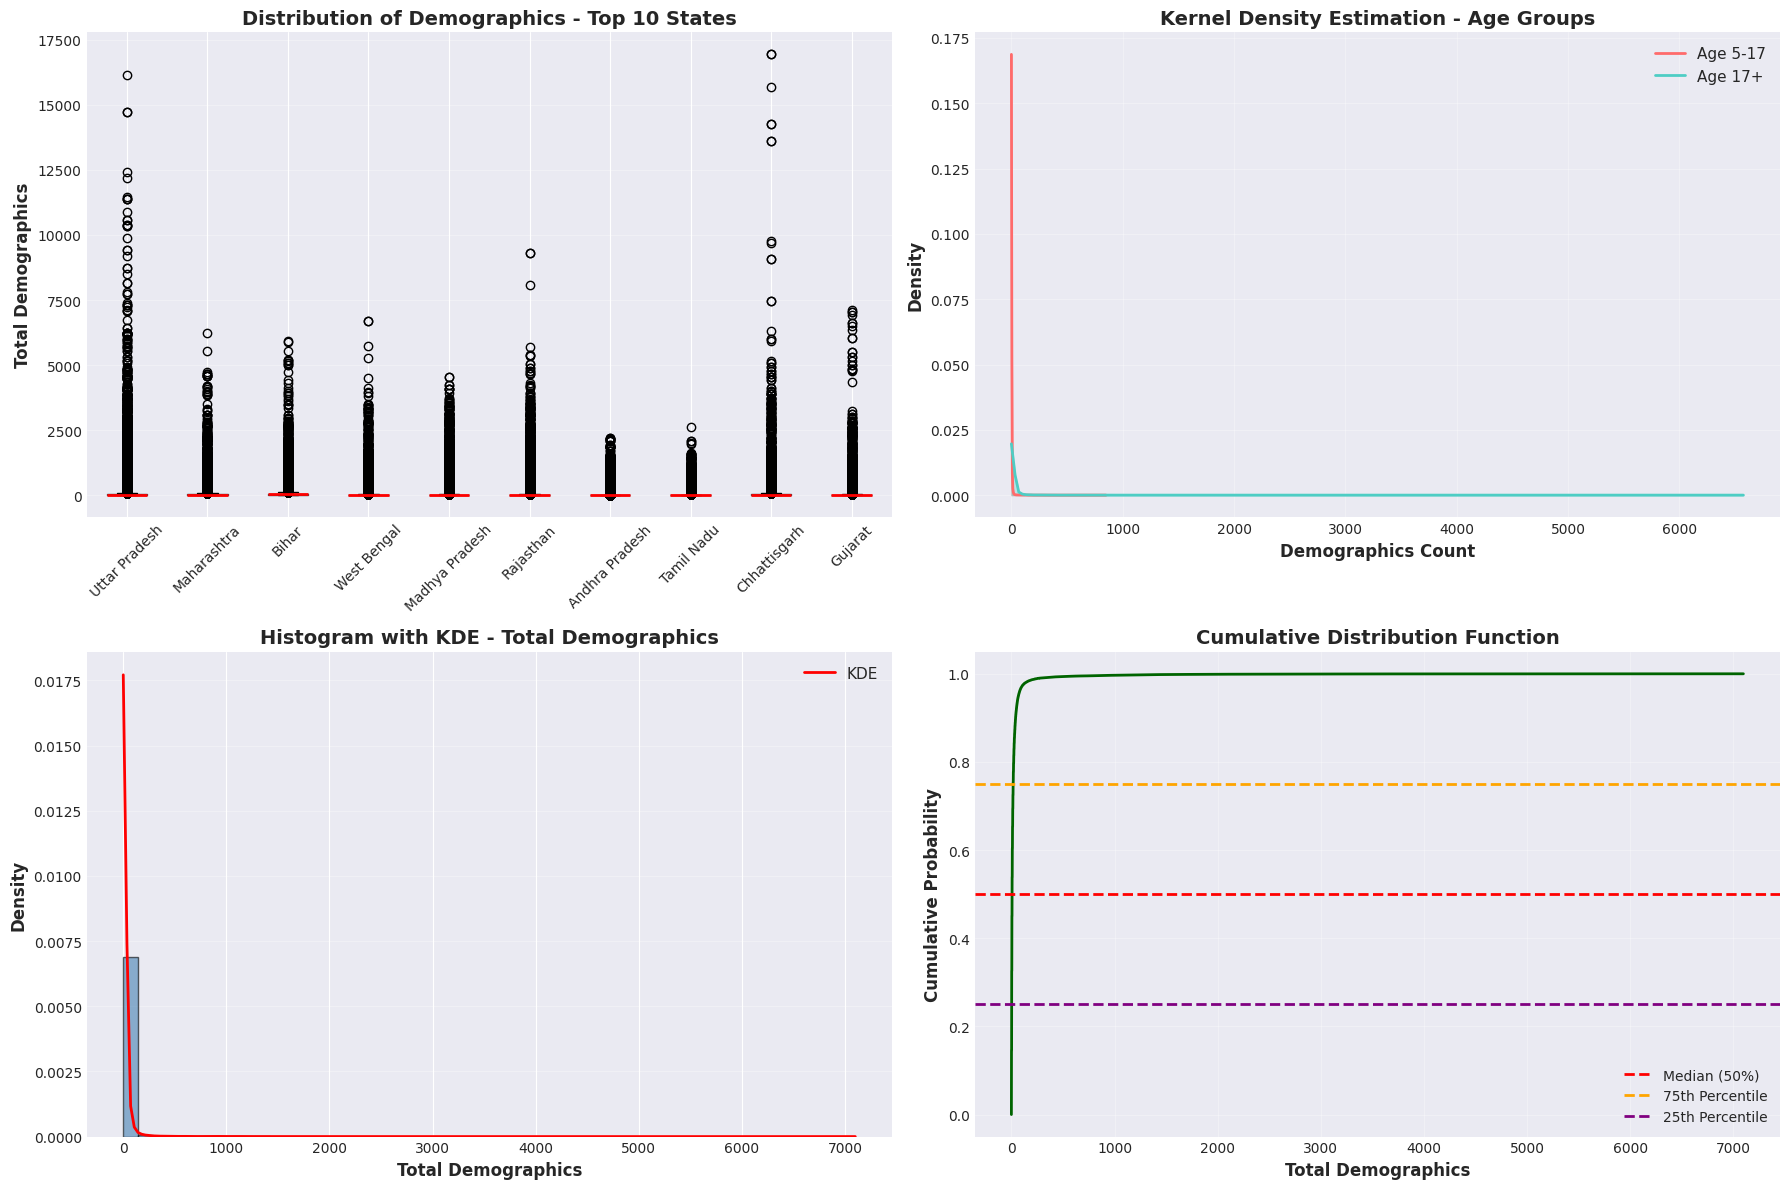

\n📊 KEY INSIGHTS:
1. Median total demographics: 7.00
2. 75th percentile: 17.00
3. 25th percentile: 3.00
4. IQR (Interquartile Range): 14.00


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Box plot for total demographics by top 10 states
top_10_states = state_stats.head(10).index
df_top10 = df[df['state'].isin(top_10_states)]

axes[0, 0].boxplot([df_top10[df_top10['state'] == state]['total_demographics'].values 
                     for state in top_10_states],
                    labels=[s[:15] for s in top_10_states], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[0, 0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution of Demographics - Top 10 States', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# KDE plot for age groups
from scipy.stats import gaussian_kde

# Sample data for KDE (to avoid memory issues)
sample_data = df.sample(min(50000, len(df)), random_state=42)

kde_age_5_17 = gaussian_kde(sample_data['demo_age_5_17'].dropna())
kde_age_17_ = gaussian_kde(sample_data['demo_age_17_'].dropna())

x_range_5_17 = np.linspace(sample_data['demo_age_5_17'].min(), sample_data['demo_age_5_17'].max(), 200)
x_range_17_ = np.linspace(sample_data['demo_age_17_'].min(), sample_data['demo_age_17_'].max(), 200)

axes[0, 1].plot(x_range_5_17, kde_age_5_17(x_range_5_17), linewidth=2, label='Age 5-17', color='#FF6B6B')
axes[0, 1].fill_between(x_range_5_17, kde_age_5_17(x_range_5_17), alpha=0.3, color='#FF6B6B')
axes[0, 1].plot(x_range_17_, kde_age_17_(x_range_17_), linewidth=2, label='Age 17+', color='#4ECDC4')
axes[0, 1].fill_between(x_range_17_, kde_age_17_(x_range_17_), alpha=0.3, color='#4ECDC4')
axes[0, 1].set_xlabel('Demographics Count', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Kernel Density Estimation - Age Groups', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='upper right', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Histogram with KDE overlay for total demographics
axes[1, 0].hist(sample_data['total_demographics'], bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='black')
kde_total = gaussian_kde(sample_data['total_demographics'].dropna())
x_range_total = np.linspace(sample_data['total_demographics'].min(), sample_data['total_demographics'].max(), 200)
axes[1, 0].plot(x_range_total, kde_total(x_range_total), linewidth=2, color='red', label='KDE')
axes[1, 0].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Histogram with KDE - Total Demographics', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper right', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Cumulative distribution
sorted_demo = np.sort(sample_data['total_demographics'])
cumulative = np.arange(1, len(sorted_demo) + 1) / len(sorted_demo)
axes[1, 1].plot(sorted_demo, cumulative, linewidth=2, color='darkgreen')
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Median (50%)')
axes[1, 1].axhline(y=0.75, color='orange', linestyle='--', linewidth=2, label='75th Percentile')
axes[1, 1].axhline(y=0.25, color='purple', linestyle='--', linewidth=2, label='25th Percentile')
axes[1, 1].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='lower right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 KEY INSIGHTS:")
print(f"1. Median total demographics: {sample_data['total_demographics'].median():.2f}")
print(f"2. 75th percentile: {sample_data['total_demographics'].quantile(0.75):.2f}")
print(f"3. 25th percentile: {sample_data['total_demographics'].quantile(0.25):.2f}")
print(f"4. IQR (Interquartile Range): {sample_data['total_demographics'].quantile(0.75) - sample_data['total_demographics'].quantile(0.25):.2f}")

## 🎯 Advanced Visualization 2: Violin Plots for Deep Distribution Analysis

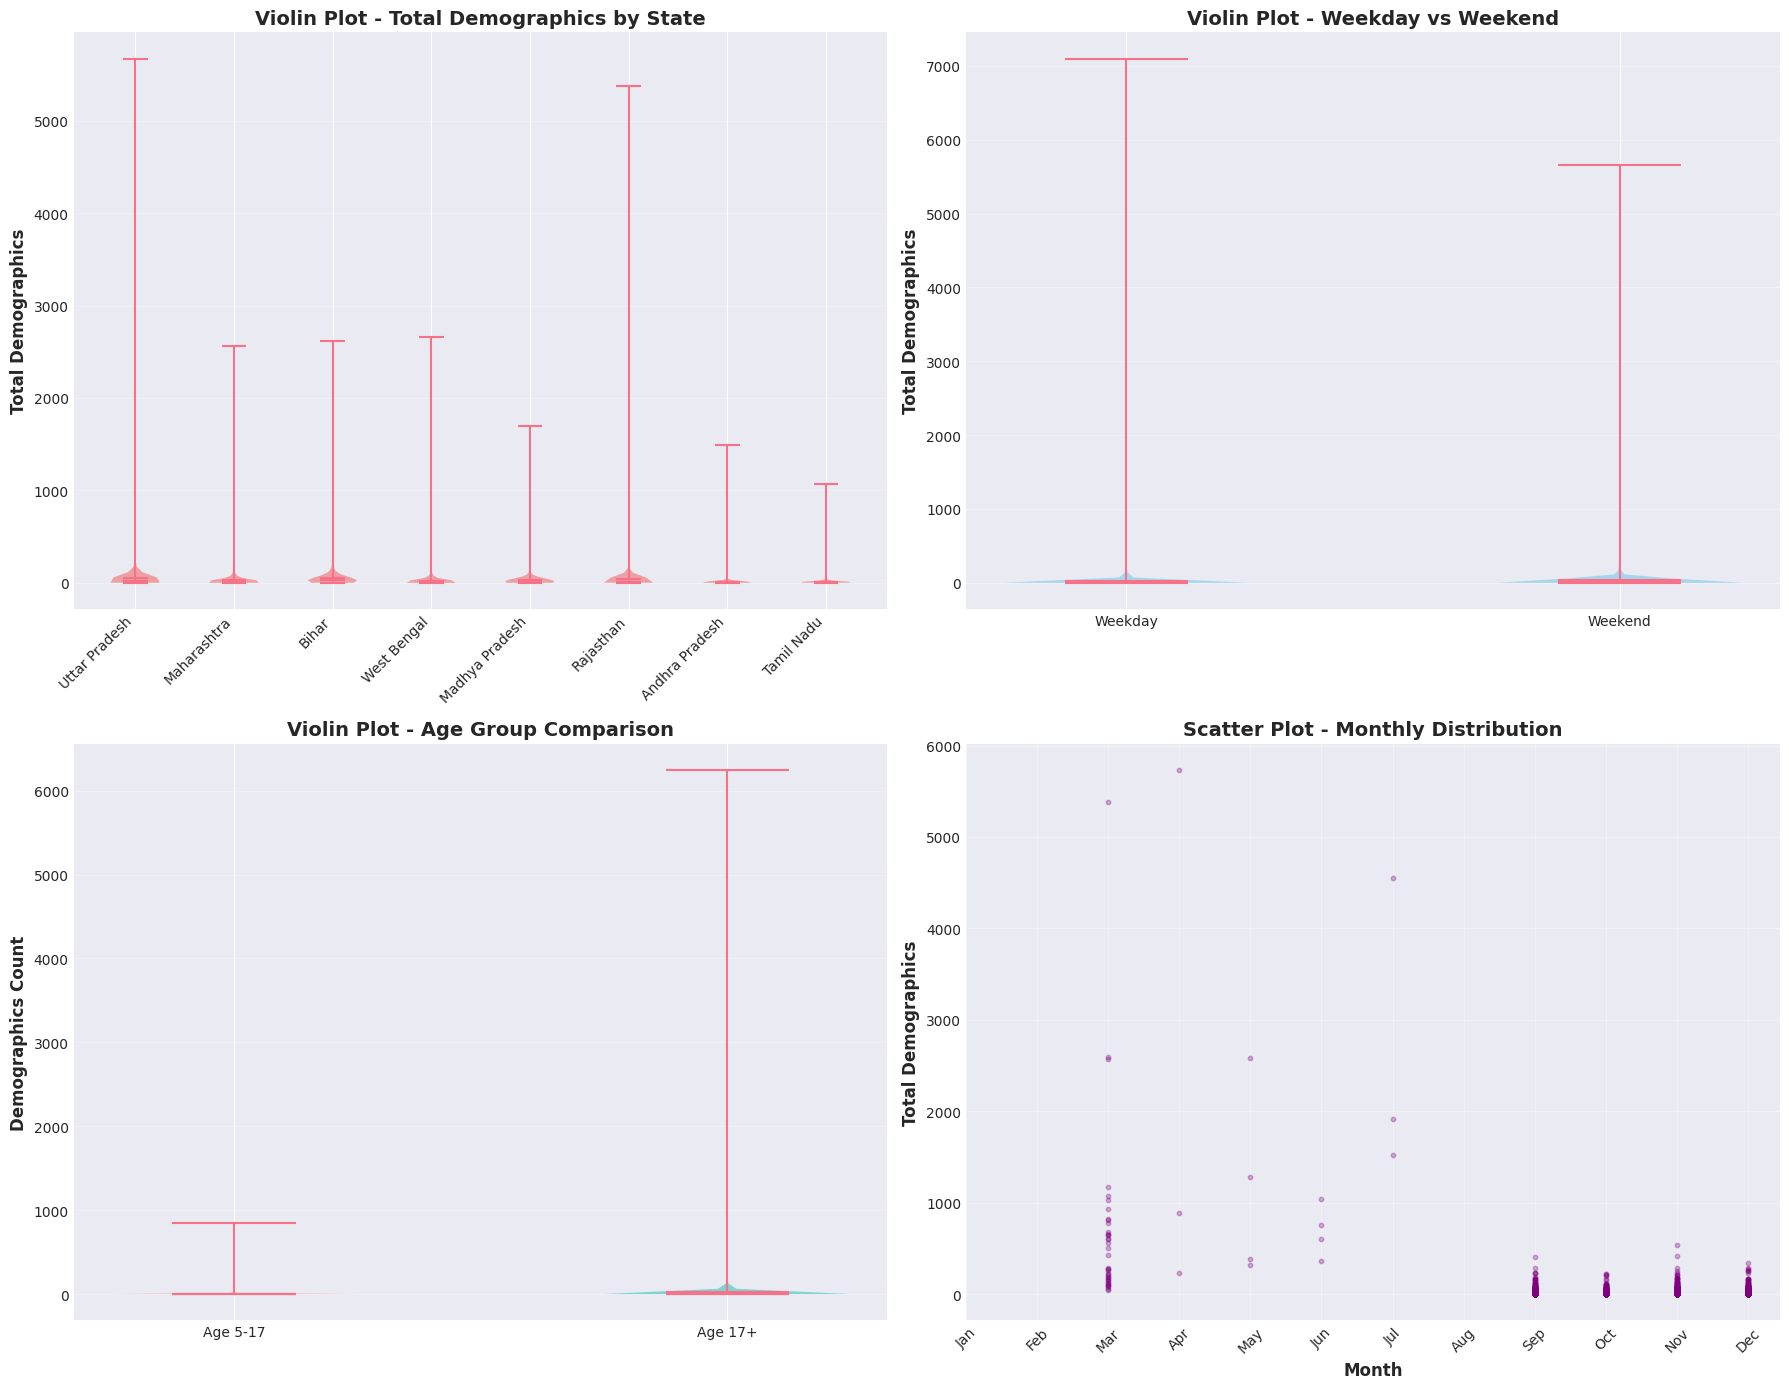

\n🎻 VIOLIN PLOT INSIGHTS:
Violin plots show the probability density of data at different values
Width indicates frequency - wider sections have more data points
Weekday mean: 20.06
Weekend mean: 36.89


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Sample data for violin plots
sample_size = min(30000, len(df))
sample_df = df.sample(sample_size, random_state=42)

# Violin plot for top 8 states
top_8_states = state_stats.head(8).index
df_top8 = sample_df[sample_df['state'].isin(top_8_states)]

parts = axes[0, 0].violinplot([df_top8[df_top8['state'] == state]['total_demographics'].values 
                                for state in top_8_states],
                               positions=range(len(top_8_states)),
                               showmeans=True, showmedians=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
axes[0, 0].set_xticks(range(len(top_8_states)))
axes[0, 0].set_xticklabels([s[:15] for s in top_8_states], rotation=45, ha='right')
axes[0, 0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Violin Plot - Total Demographics by State', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Violin plot: weekday vs weekend
parts = axes[0, 1].violinplot([sample_df[sample_df['is_weekend'] == 0]['total_demographics'].values,
                                sample_df[sample_df['is_weekend'] == 1]['total_demographics'].values],
                               positions=[0, 1],
                               showmeans=True, showmedians=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_alpha(0.7)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Weekday', 'Weekend'])
axes[0, 1].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Violin Plot - Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Violin plot: age groups comparison
parts = axes[1, 0].violinplot([sample_df['demo_age_5_17'].values,
                                sample_df['demo_age_17_'].values],
                               positions=[0, 1],
                               showmeans=True, showmedians=True, showextrema=True)
colors = ['#FF6B6B', '#4ECDC4']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Age 5-17', 'Age 17+'])
axes[1, 0].set_ylabel('Demographics Count', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Violin Plot - Age Group Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Swarm plot for monthly distribution (sample)
monthly_sample = sample_df.sample(min(5000, len(sample_df)), random_state=42)
axes[1, 1].scatter(monthly_sample['month'], monthly_sample['total_demographics'], 
                   alpha=0.3, s=10, color='purple')
axes[1, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Scatter Plot - Monthly Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n🎻 VIOLIN PLOT INSIGHTS:")
print("Violin plots show the probability density of data at different values")
print("Width indicates frequency - wider sections have more data points")
print(f"Weekday mean: {sample_df[sample_df['is_weekend'] == 0]['total_demographics'].mean():.2f}")
print(f"Weekend mean: {sample_df[sample_df['is_weekend'] == 1]['total_demographics'].mean():.2f}")

## 🎯 Advanced Visualization 3: Time Series Decomposition with Trend & Seasonality

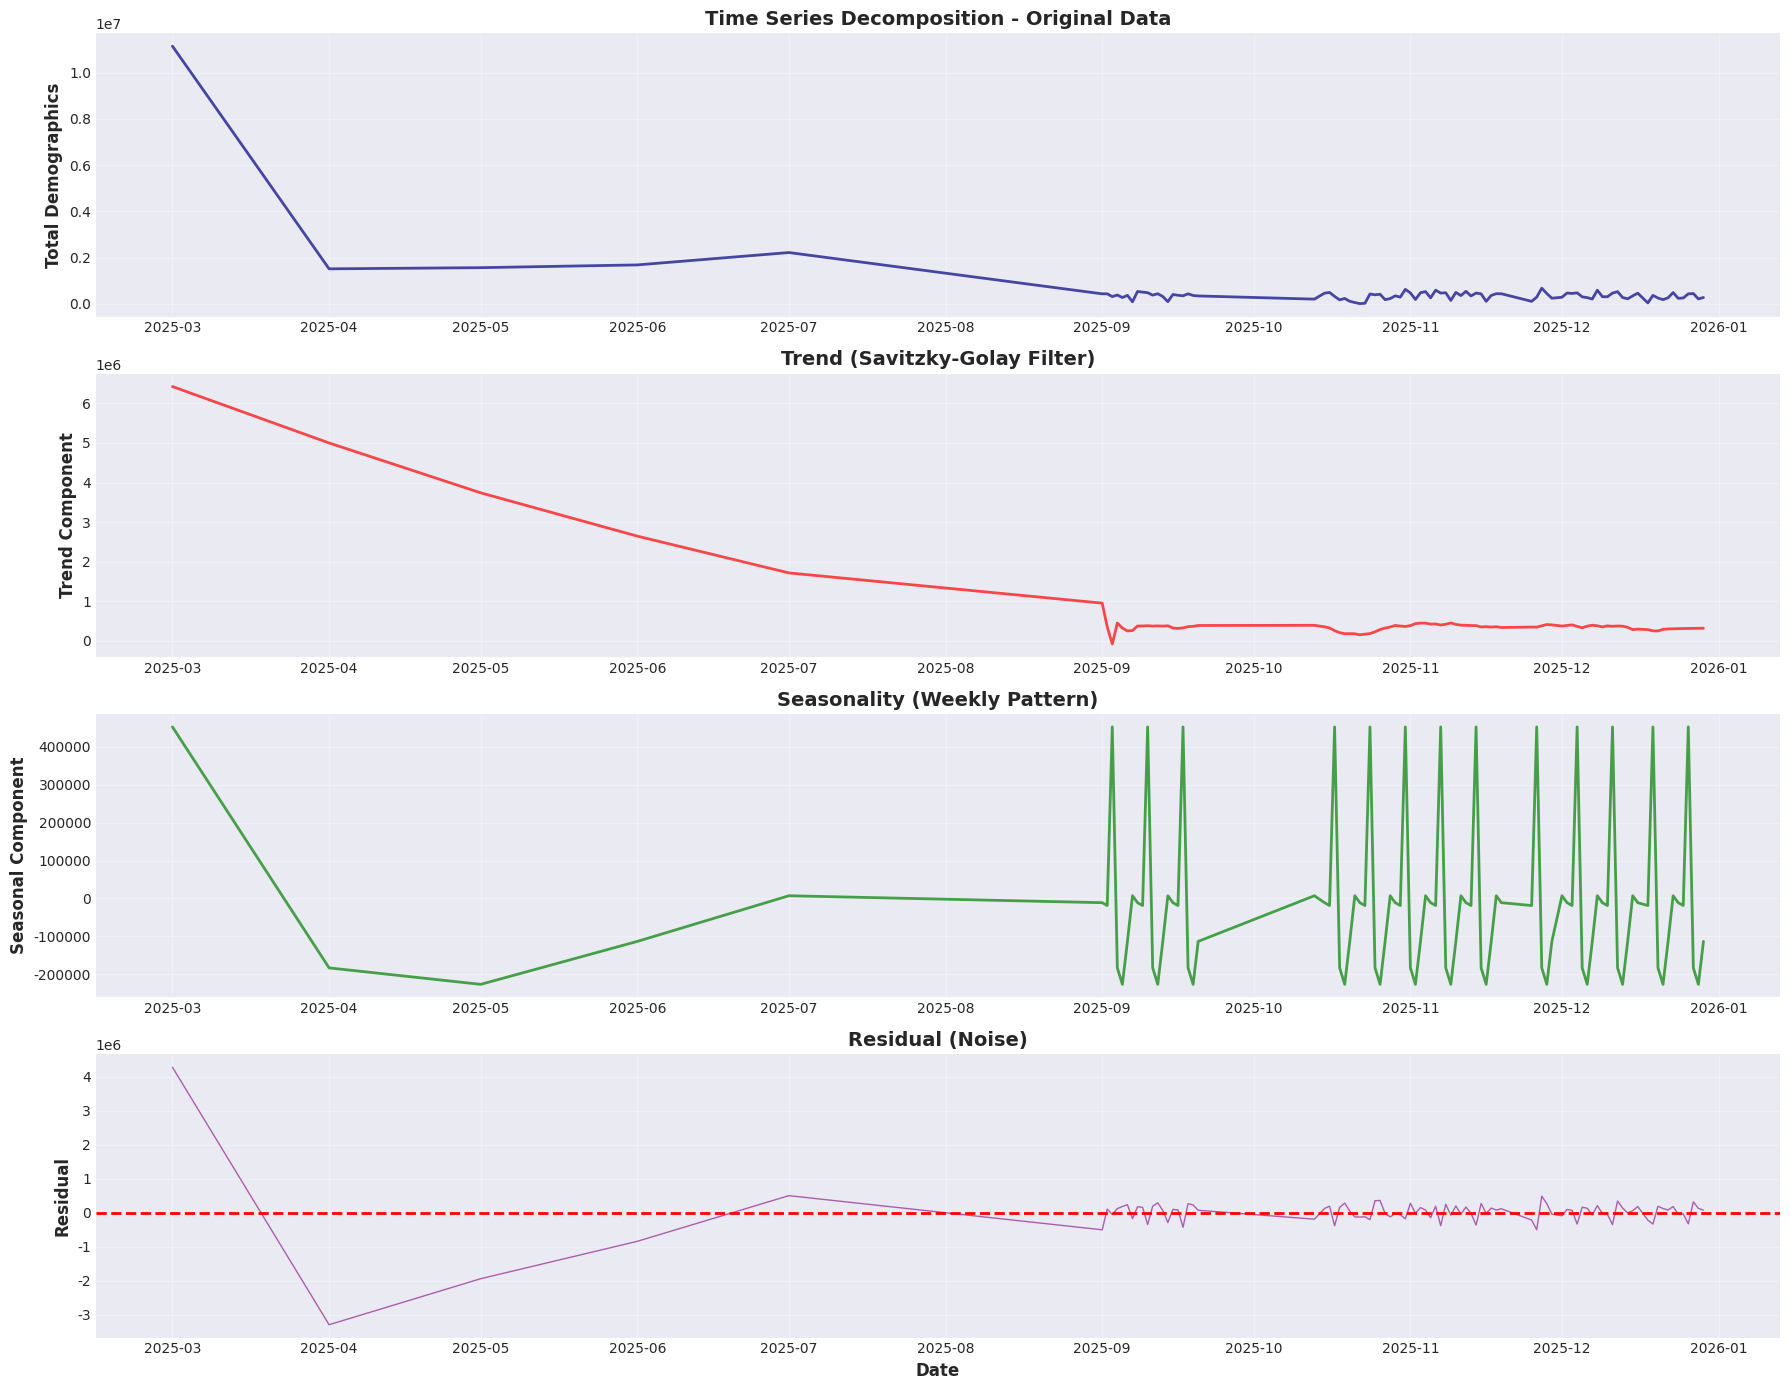

\n📈 TIME SERIES DECOMPOSITION INSIGHTS:
1. Trend shows overall direction of demographic data
2. Seasonal component reveals weekly patterns
3. Residual represents random noise and anomalies
4. Mean residual: 0.00 (should be close to 0)
5. Std of residual: 632706.05


In [27]:
from scipy.signal import savgol_filter

# Prepare daily time series
ts_data = daily_age_ts.set_index('date')['total_demographics'].sort_index()

# Calculate components
window_length = min(15, len(ts_data) if len(ts_data) % 2 == 1 else len(ts_data) - 1)
if window_length < 5:
    window_length = 5

trend = savgol_filter(ts_data.values, window_length=window_length, polyorder=2)
detrended = ts_data.values - trend
seasonal_period = 7  # Weekly seasonality
seasonal = np.array([detrended[i::seasonal_period].mean() for i in range(seasonal_period)])
seasonal_full = np.tile(seasonal, len(ts_data) // seasonal_period + 1)[:len(ts_data)]
residual = detrended - seasonal_full

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(18, 14))

# Original
axes[0].plot(ts_data.index, ts_data.values, linewidth=2, color='navy', alpha=0.7)
axes[0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[0].set_title('Time Series Decomposition - Original Data', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(ts_data.index, trend, linewidth=2, color='red', alpha=0.7)
axes[1].set_ylabel('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_title('Trend (Savitzky-Golay Filter)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(ts_data.index, seasonal_full, linewidth=2, color='green', alpha=0.7)
axes[2].set_ylabel('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_title('Seasonality (Weekly Pattern)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(ts_data.index, residual, linewidth=1, color='purple', alpha=0.6)
axes[3].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[3].set_ylabel('Residual', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].set_title('Residual (Noise)', fontsize=14, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📈 TIME SERIES DECOMPOSITION INSIGHTS:")
print(f"1. Trend shows overall direction of demographic data")
print(f"2. Seasonal component reveals weekly patterns")
print(f"3. Residual represents random noise and anomalies")
print(f"4. Mean residual: {residual.mean():.2f} (should be close to 0)")
print(f"5. Std of residual: {residual.std():.2f}")

## 🎯 Advanced Visualization 4: Growth Rate Analysis (WoW & MoM)

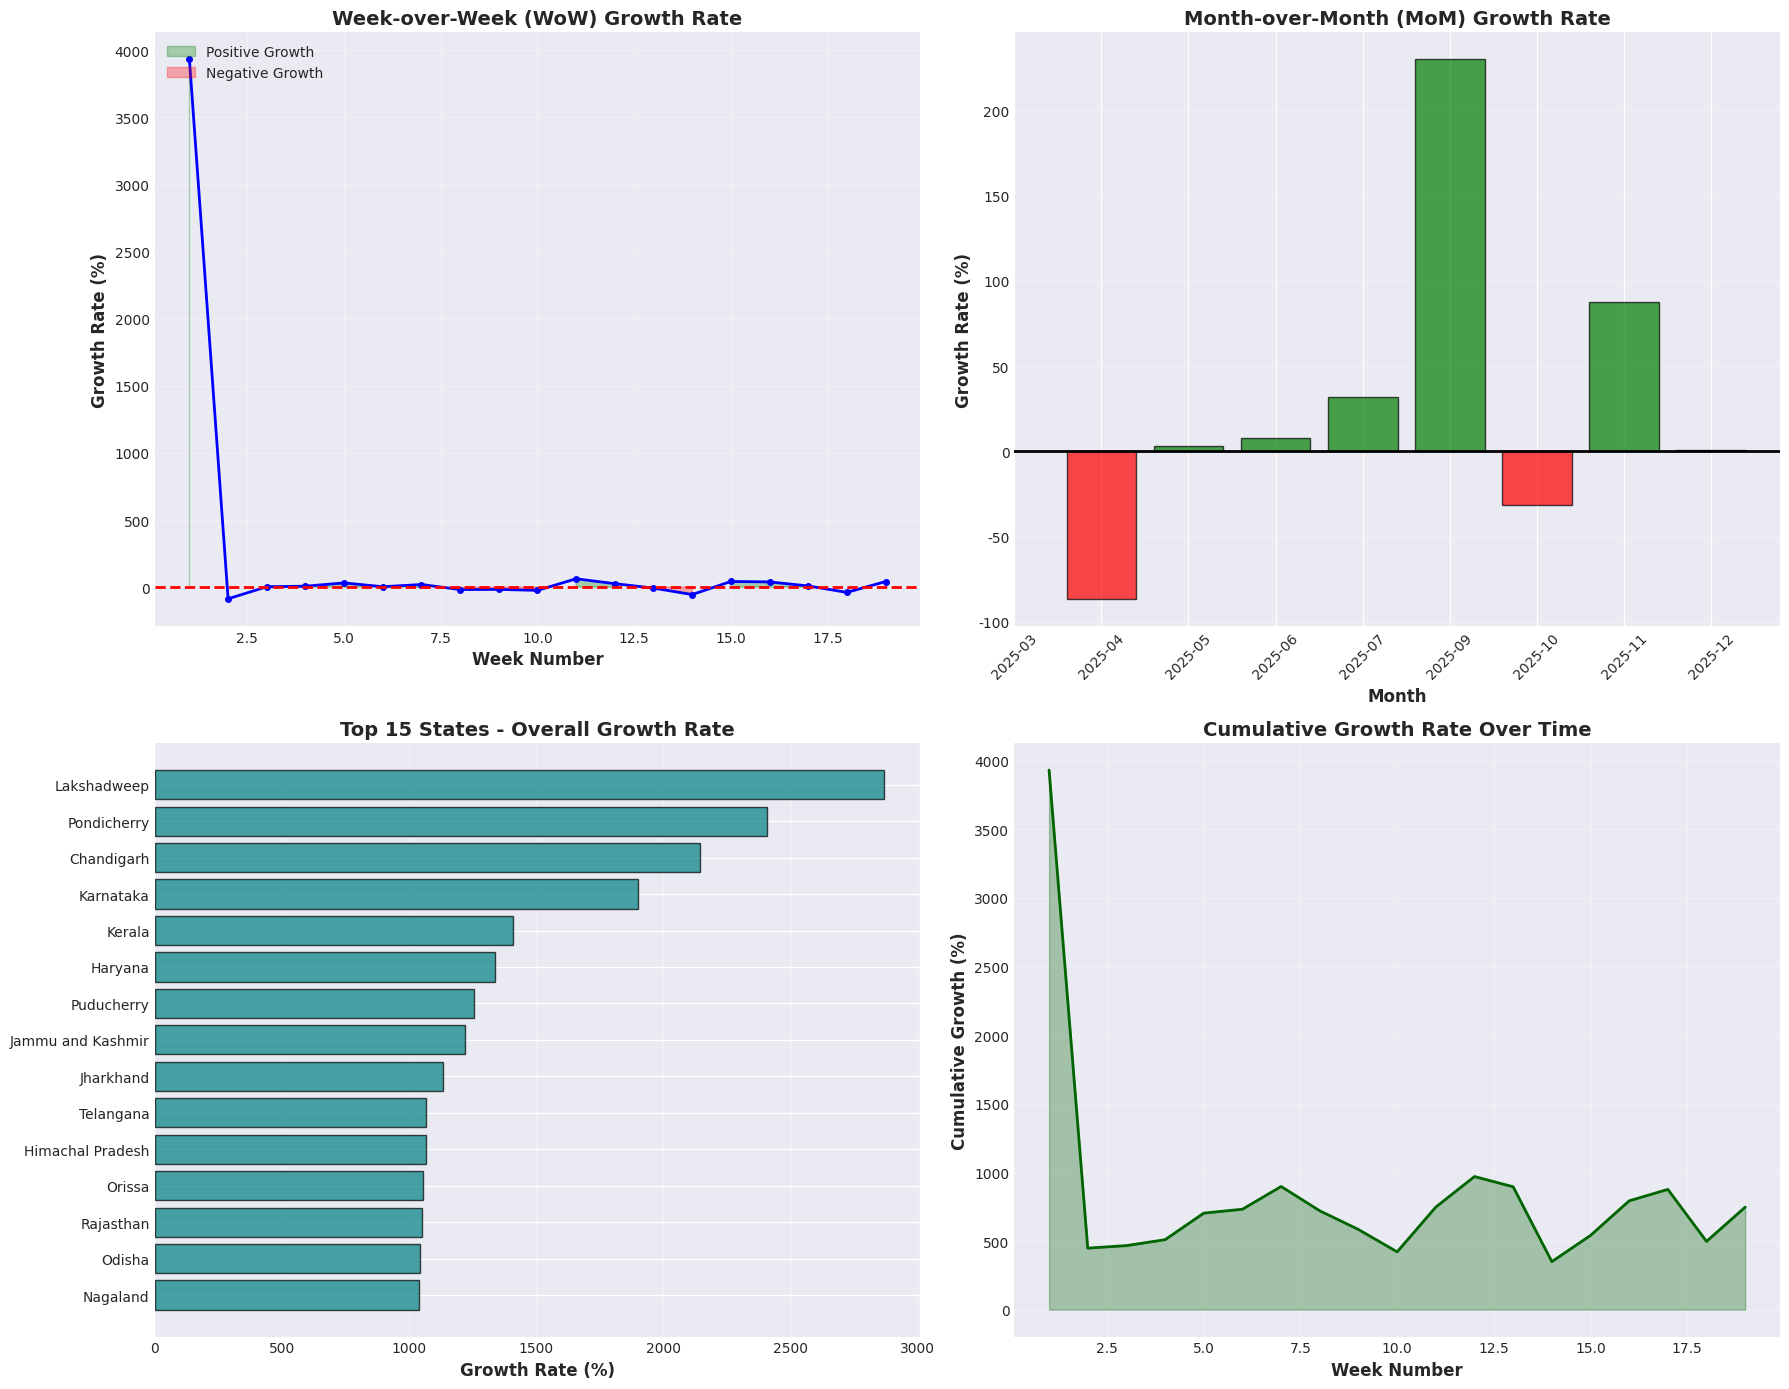

\n📊 GROWTH RATE INSIGHTS:
1. Average WoW growth: 209.18%
2. Average MoM growth: 30.30%
3. Highest WoW growth: 3931.67%
4. Lowest WoW growth: -86.40%
5. Total cumulative growth: 746.85%


In [28]:
# Calculate week-over-week growth
weekly_data = df.groupby(['year', 'week']).agg({
    'total_demographics': 'sum'
}).reset_index()
weekly_data['WoW_growth'] = weekly_data['total_demographics'].pct_change() * 100

# Calculate month-over-month growth
monthly_data = df.groupby(['year', 'month']).agg({
    'total_demographics': 'sum'
}).reset_index()
monthly_data['MoM_growth'] = monthly_data['total_demographics'].pct_change() * 100

# State-wise growth analysis (comparing first vs last week)
state_growth = df.groupby(['state', 'year', 'week']).agg({
    'total_demographics': 'sum'
}).reset_index()

first_week = state_growth.groupby('state').first()
last_week = state_growth.groupby('state').last()
state_growth_pct = ((last_week['total_demographics'] - first_week['total_demographics']) / 
                    first_week['total_demographics'] * 100).sort_values(ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Week-over-week growth
axes[0, 0].plot(range(len(weekly_data)), weekly_data['WoW_growth'], linewidth=2, color='blue', marker='o', markersize=4)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].fill_between(range(len(weekly_data)), weekly_data['WoW_growth'], 0, 
                        where=(weekly_data['WoW_growth'] > 0), alpha=0.3, color='green', label='Positive Growth')
axes[0, 0].fill_between(range(len(weekly_data)), weekly_data['WoW_growth'], 0, 
                        where=(weekly_data['WoW_growth'] <= 0), alpha=0.3, color='red', label='Negative Growth')
axes[0, 0].set_ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Week Number', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Week-over-Week (WoW) Growth Rate', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Month-over-month growth
month_labels = [f"{int(row['year'])}-{int(row['month']):02d}" for _, row in monthly_data.iterrows()]
axes[0, 1].bar(range(len(monthly_data)), monthly_data['MoM_growth'], 
               color=['green' if x > 0 else 'red' for x in monthly_data['MoM_growth']], alpha=0.7, edgecolor='black')
axes[0, 1].axhline(y=0, color='black', linewidth=2)
axes[0, 1].set_ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Month-over-Month (MoM) Growth Rate', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(0, len(monthly_data), max(1, len(monthly_data)//10)))
axes[0, 1].set_xticklabels([month_labels[i] for i in range(0, len(monthly_data), max(1, len(monthly_data)//10))], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# State growth comparison (top 15)
top_15_growth = state_growth_pct.head(15)
axes[1, 0].barh(range(len(top_15_growth)), top_15_growth.values, color='teal', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_15_growth)))
axes[1, 0].set_yticklabels(top_15_growth.index, fontsize=10)
axes[1, 0].set_xlabel('Growth Rate (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 15 States - Overall Growth Rate', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Cumulative growth over time
weekly_data['cumulative_growth'] = (1 + weekly_data['WoW_growth']/100).cumprod() - 1
axes[1, 1].plot(range(len(weekly_data)), weekly_data['cumulative_growth'] * 100, linewidth=2, color='darkgreen')
axes[1, 1].fill_between(range(len(weekly_data)), weekly_data['cumulative_growth'] * 100, alpha=0.3, color='darkgreen')
axes[1, 1].set_ylabel('Cumulative Growth (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Week Number', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Cumulative Growth Rate Over Time', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 GROWTH RATE INSIGHTS:")
print(f"1. Average WoW growth: {weekly_data['WoW_growth'].mean():.2f}%")
print(f"2. Average MoM growth: {monthly_data['MoM_growth'].mean():.2f}%")
print(f"3. Highest WoW growth: {weekly_data['WoW_growth'].max():.2f}%")
print(f"4. Lowest WoW growth: {weekly_data['WoW_growth'].min():.2f}%")
print(f"5. Total cumulative growth: {weekly_data['cumulative_growth'].iloc[-1] * 100:.2f}%")

## 🎯 Advanced Visualization 5: Lorenz Curve & Gini Coefficient (Inequality Analysis)

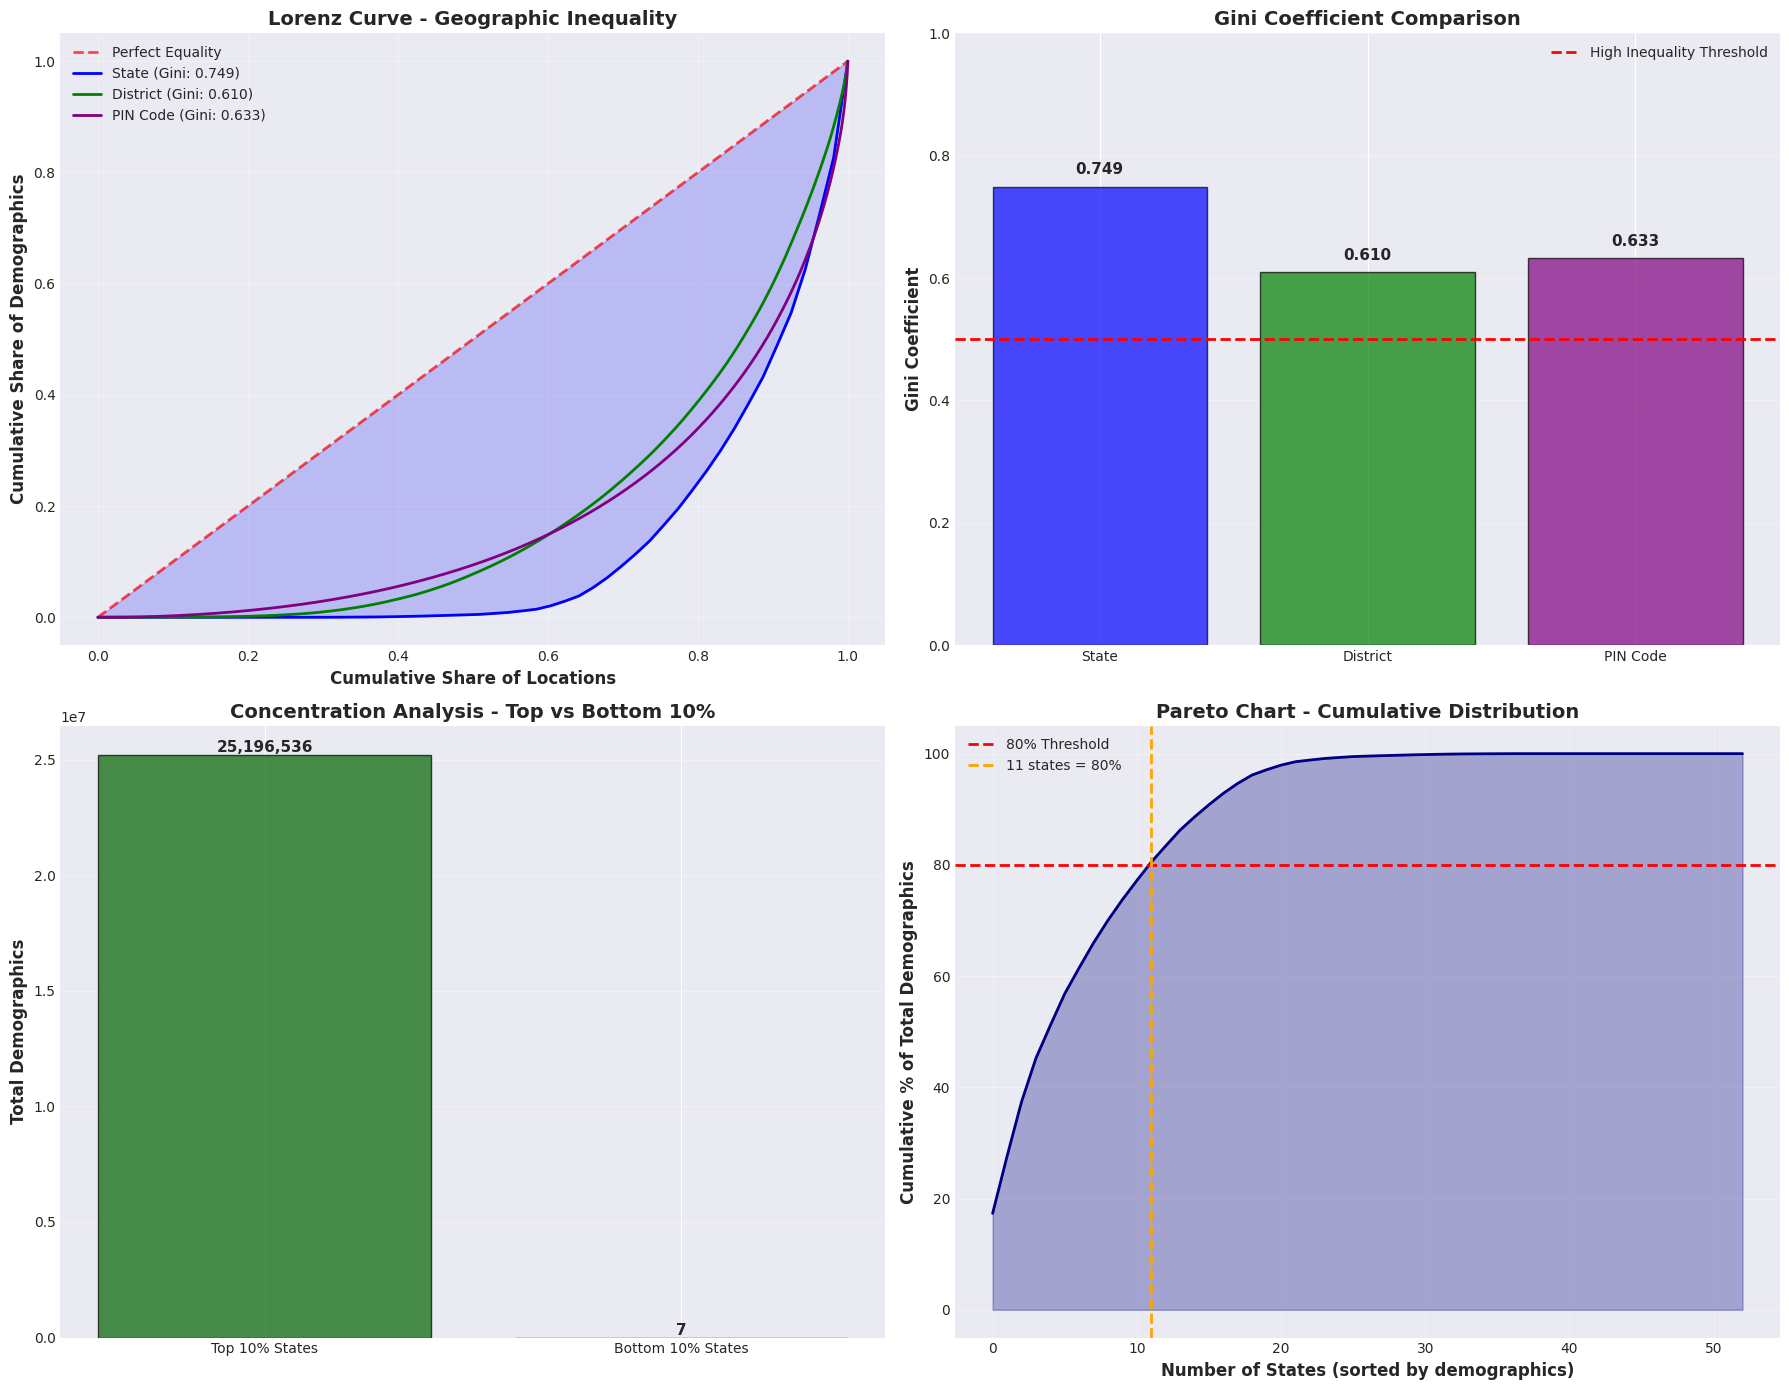

\n📊 INEQUALITY ANALYSIS INSIGHTS:
1. State-level Gini: 0.749 (0=perfect equality, 1=perfect inequality)
2. District-level Gini: 0.610
3. PIN code-level Gini: 0.633
4. 11 states (out of 53) account for 80% of demographics
5. Top 10% states: 25,196,536 demographics
6. Bottom 10% states: 7 demographics
7. Ratio (Top/Bottom): 3599505.14x


In [29]:
def gini_coefficient(values):
    """Calculate Gini coefficient for inequality measurement"""
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate Lorenz curve data for different levels
def lorenz_curve(values):
    sorted_values = np.sort(values)
    cumsum = np.cumsum(sorted_values)
    return np.insert(cumsum / cumsum[-1], 0, 0)

# State-level inequality
state_totals = state_stats['Total_Demo'].values
state_lorenz = lorenz_curve(state_totals)
state_gini = gini_coefficient(state_totals)

# District-level inequality
district_totals = district_stats['Total_Demo'].values
district_lorenz = lorenz_curve(district_totals)
district_gini = gini_coefficient(district_totals)

# PIN code-level inequality
pincode_totals = pincode_stats['Total_Demo'].values
pincode_lorenz = lorenz_curve(pincode_totals)
pincode_gini = gini_coefficient(pincode_totals)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Lorenz curves comparison
x_perfect = np.linspace(0, 1, len(state_lorenz))
axes[0, 0].plot(x_perfect, x_perfect, 'r--', linewidth=2, label='Perfect Equality', alpha=0.7)
axes[0, 0].plot(np.linspace(0, 1, len(state_lorenz)), state_lorenz, linewidth=2, label=f'State (Gini: {state_gini:.3f})', color='blue')
axes[0, 0].plot(np.linspace(0, 1, len(district_lorenz)), district_lorenz, linewidth=2, label=f'District (Gini: {district_gini:.3f})', color='green')
axes[0, 0].plot(np.linspace(0, 1, len(pincode_lorenz)), pincode_lorenz, linewidth=2, label=f'PIN Code (Gini: {pincode_gini:.3f})', color='purple')
axes[0, 0].fill_between(x_perfect, x_perfect, state_lorenz[:len(x_perfect)], alpha=0.2, color='blue')
axes[0, 0].set_xlabel('Cumulative Share of Locations', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Share of Demographics', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Lorenz Curve - Geographic Inequality', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='upper left', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Gini coefficient comparison
gini_values = [state_gini, district_gini, pincode_gini]
gini_labels = ['State', 'District', 'PIN Code']
colors_gini = ['blue', 'green', 'purple']
axes[0, 1].bar(gini_labels, gini_values, color=colors_gini, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Gini Coefficient', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Gini Coefficient Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='High Inequality Threshold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(gini_values):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

# Concentration analysis - Top vs Bottom
state_sorted = state_stats['Total_Demo'].sort_values(ascending=False)
top_10_pct = state_sorted.head(int(len(state_sorted) * 0.1)).sum()
bottom_10_pct = state_sorted.tail(int(len(state_sorted) * 0.1)).sum()
concentration_data = [top_10_pct, bottom_10_pct]
concentration_labels = ['Top 10% States', 'Bottom 10% States']

axes[1, 0].bar(concentration_labels, concentration_data, color=['darkgreen', 'darkred'], alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Concentration Analysis - Top vs Bottom 10%', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(concentration_data):
    axes[1, 0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pareto chart - 80/20 rule
state_cumsum = state_sorted.cumsum()
state_cum_pct = (state_cumsum / state_cumsum.iloc[-1]) * 100
axes[1, 1].plot(range(len(state_cum_pct)), state_cum_pct.values, linewidth=2, color='navy')
axes[1, 1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
axes[1, 1].fill_between(range(len(state_cum_pct)), state_cum_pct.values, alpha=0.3, color='navy')
axes[1, 1].set_xlabel('Number of States (sorted by demographics)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative % of Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Pareto Chart - Cumulative Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Find how many states contribute to 80%
states_for_80 = (state_cum_pct <= 80).sum()
axes[1, 1].axvline(x=states_for_80, color='orange', linestyle='--', linewidth=2, label=f'{states_for_80} states = 80%')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\\n📊 INEQUALITY ANALYSIS INSIGHTS:")
print(f"1. State-level Gini: {state_gini:.3f} (0=perfect equality, 1=perfect inequality)")
print(f"2. District-level Gini: {district_gini:.3f}")
print(f"3. PIN code-level Gini: {pincode_gini:.3f}")
print(f"4. {states_for_80} states (out of {len(state_sorted)}) account for 80% of demographics")
print(f"5. Top 10% states: {top_10_pct:,.0f} demographics")
print(f"6. Bottom 10% states: {bottom_10_pct:,.0f} demographics")
print(f"7. Ratio (Top/Bottom): {top_10_pct/bottom_10_pct:.2f}x")

## 🎯 Advanced Visualization 6: Multi-Dimensional Heatmaps & Correlation Analysis

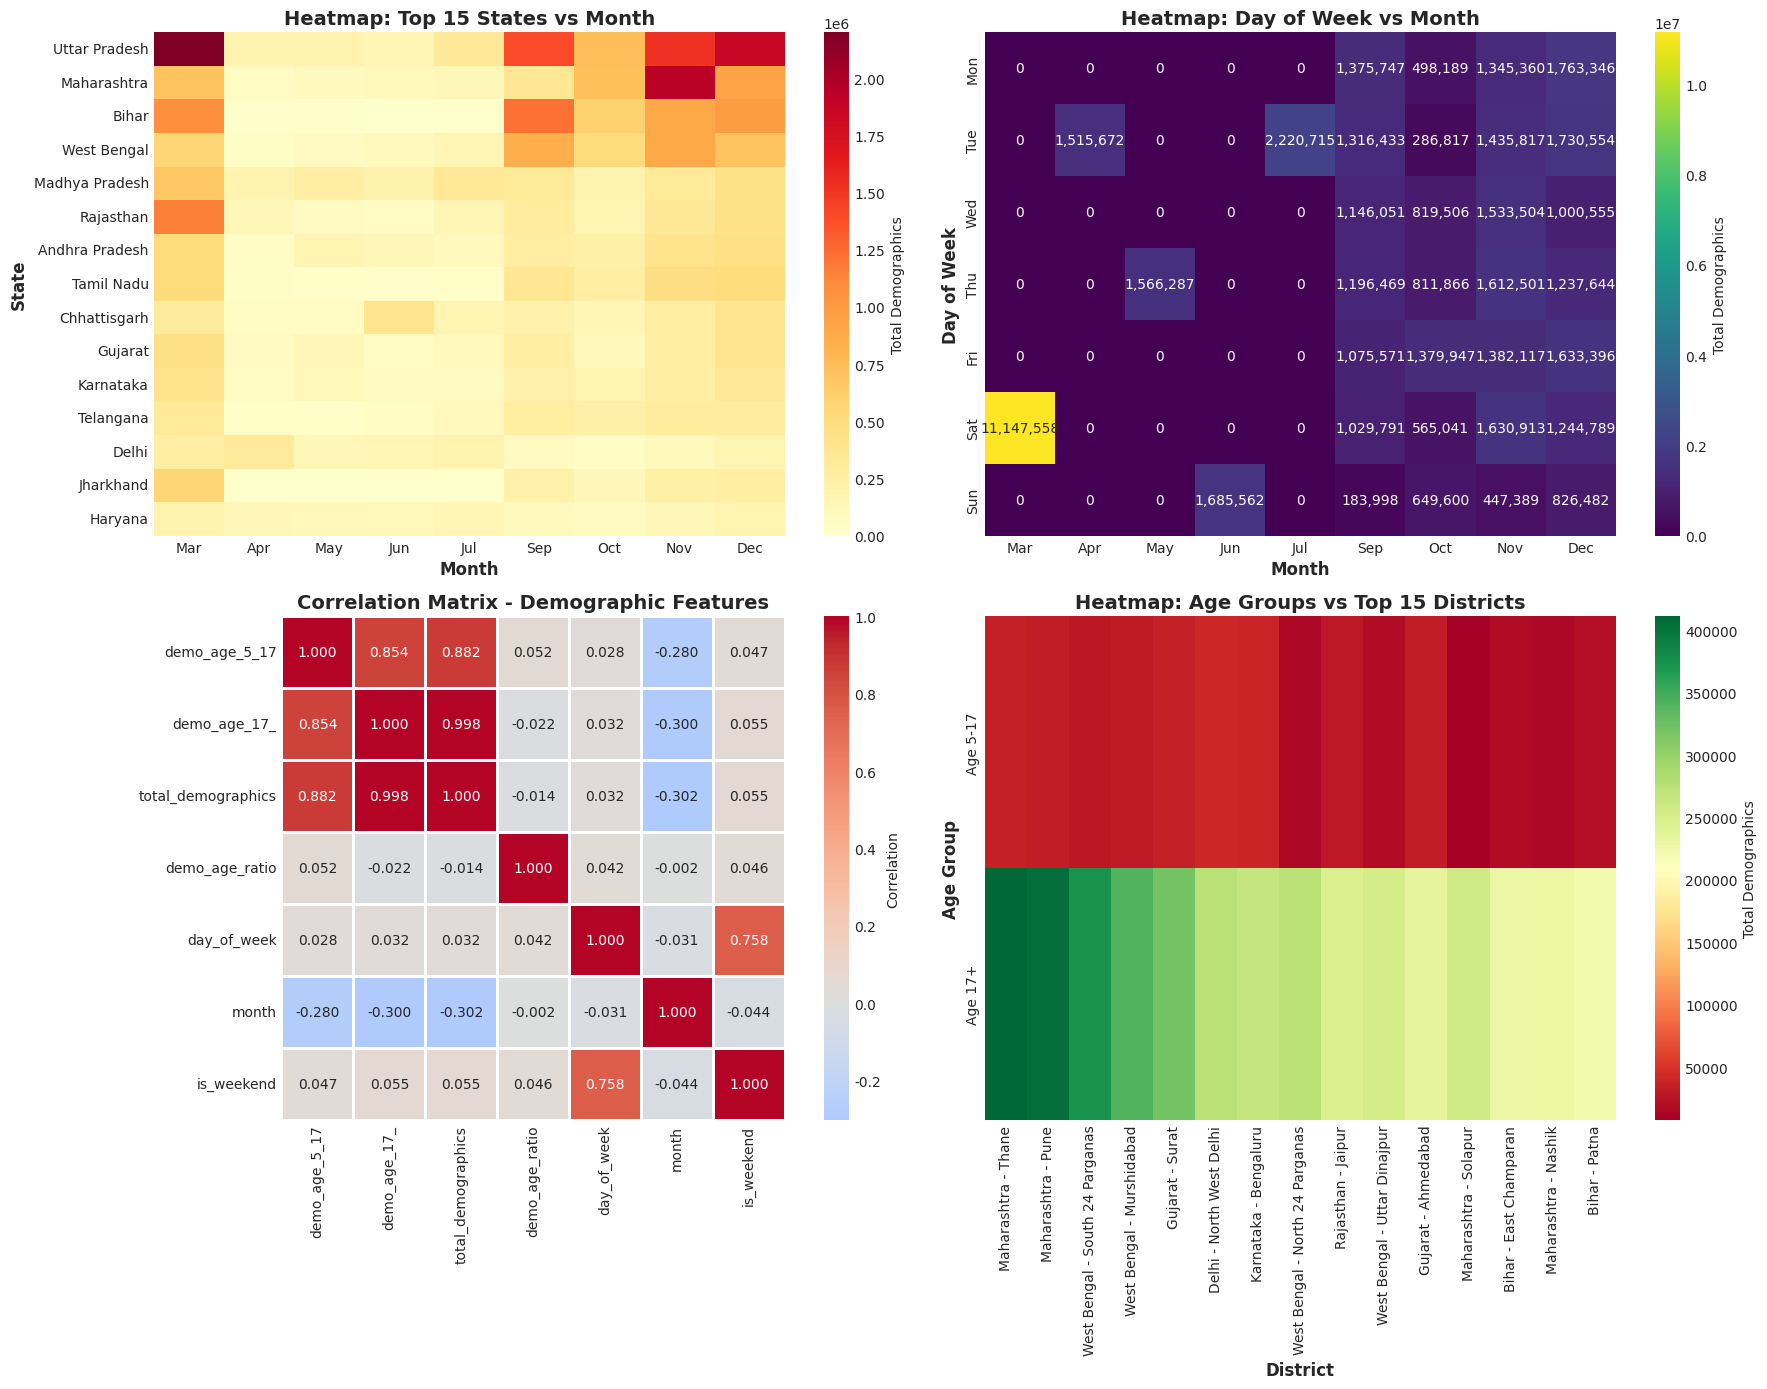


🔥 HEATMAP & CORRELATION INSIGHTS:
1. Strongest positive correlation: 0.998
2. Strongest negative correlation: -0.302
3. Age groups correlation: 0.854
4. Weekend effect correlation: 0.055


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Heatmap: State vs Month
state_month_pivot = df.groupby(['state', 'month'])['total_demographics'].sum().unstack(fill_value=0)
top_states_hm = state_stats.head(15).index
state_month_pivot_top = state_month_pivot.loc[top_states_hm]

# Get actual month names for columns that exist in the data
month_names_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
actual_month_labels = [month_names_map[m] for m in state_month_pivot_top.columns]

sns.heatmap(state_month_pivot_top, cmap='YlOrRd', annot=False, fmt=',.0f', 
            cbar_kws={'label': 'Total Demographics'}, ax=axes[0, 0])
axes[0, 0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('State', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Heatmap: Top 15 States vs Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xticklabels(actual_month_labels, rotation=0)

# Heatmap: Day of Week vs Month
dow_month_pivot = df.groupby(['day_of_week', 'month'])['total_demographics'].sum().unstack(fill_value=0)
dow_month_pivot.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Get actual month names for columns that exist in the data
actual_month_labels_dow = [month_names_map[m] for m in dow_month_pivot.columns]

sns.heatmap(dow_month_pivot, cmap='viridis', annot=True, fmt=',.0f', 
            cbar_kws={'label': 'Total Demographics'}, ax=axes[0, 1])
axes[0, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Heatmap: Day of Week vs Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(actual_month_labels_dow, rotation=0)

# Correlation matrix
corr_data = df[['demo_age_5_17', 'demo_age_17_', 'total_demographics', 
                'demo_age_ratio', 'day_of_week', 'month', 'is_weekend']].corr()

sns.heatmap(corr_data, cmap='coolwarm', annot=True, fmt='.3f', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix - Demographic Features', fontsize=14, fontweight='bold')

# Age group heatmap by top districts
top_districts_hm = district_stats.head(15)
age_district_data = pd.DataFrame({
    'Age 5-17': top_districts_hm['Total_Age_5_17'],
    'Age 17+': top_districts_hm['Total_Age_17_']
})
district_labels_hm = [f"{state} - {dist}" for state, dist in top_districts_hm.index]
age_district_data.index = district_labels_hm

sns.heatmap(age_district_data.T, cmap='RdYlGn', annot=False, fmt=',.0f',
            cbar_kws={'label': 'Total Demographics'}, ax=axes[1, 1])
axes[1, 1].set_xlabel('District', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Age Group', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Heatmap: Age Groups vs Top 15 Districts', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

print("\n🔥 HEATMAP & CORRELATION INSIGHTS:")
print(f"1. Strongest positive correlation: {corr_data.values[np.triu_indices_from(corr_data.values, k=1)].max():.3f}")
print(f"2. Strongest negative correlation: {corr_data.values[np.triu_indices_from(corr_data.values, k=1)].min():.3f}")
print(f"3. Age groups correlation: {corr_data.loc['demo_age_5_17', 'demo_age_17_']:.3f}")
print(f"4. Weekend effect correlation: {corr_data.loc['is_weekend', 'total_demographics']:.3f}")

## 🎯 Advanced Visualization 7: State Performance Ranking Evolution Over Time

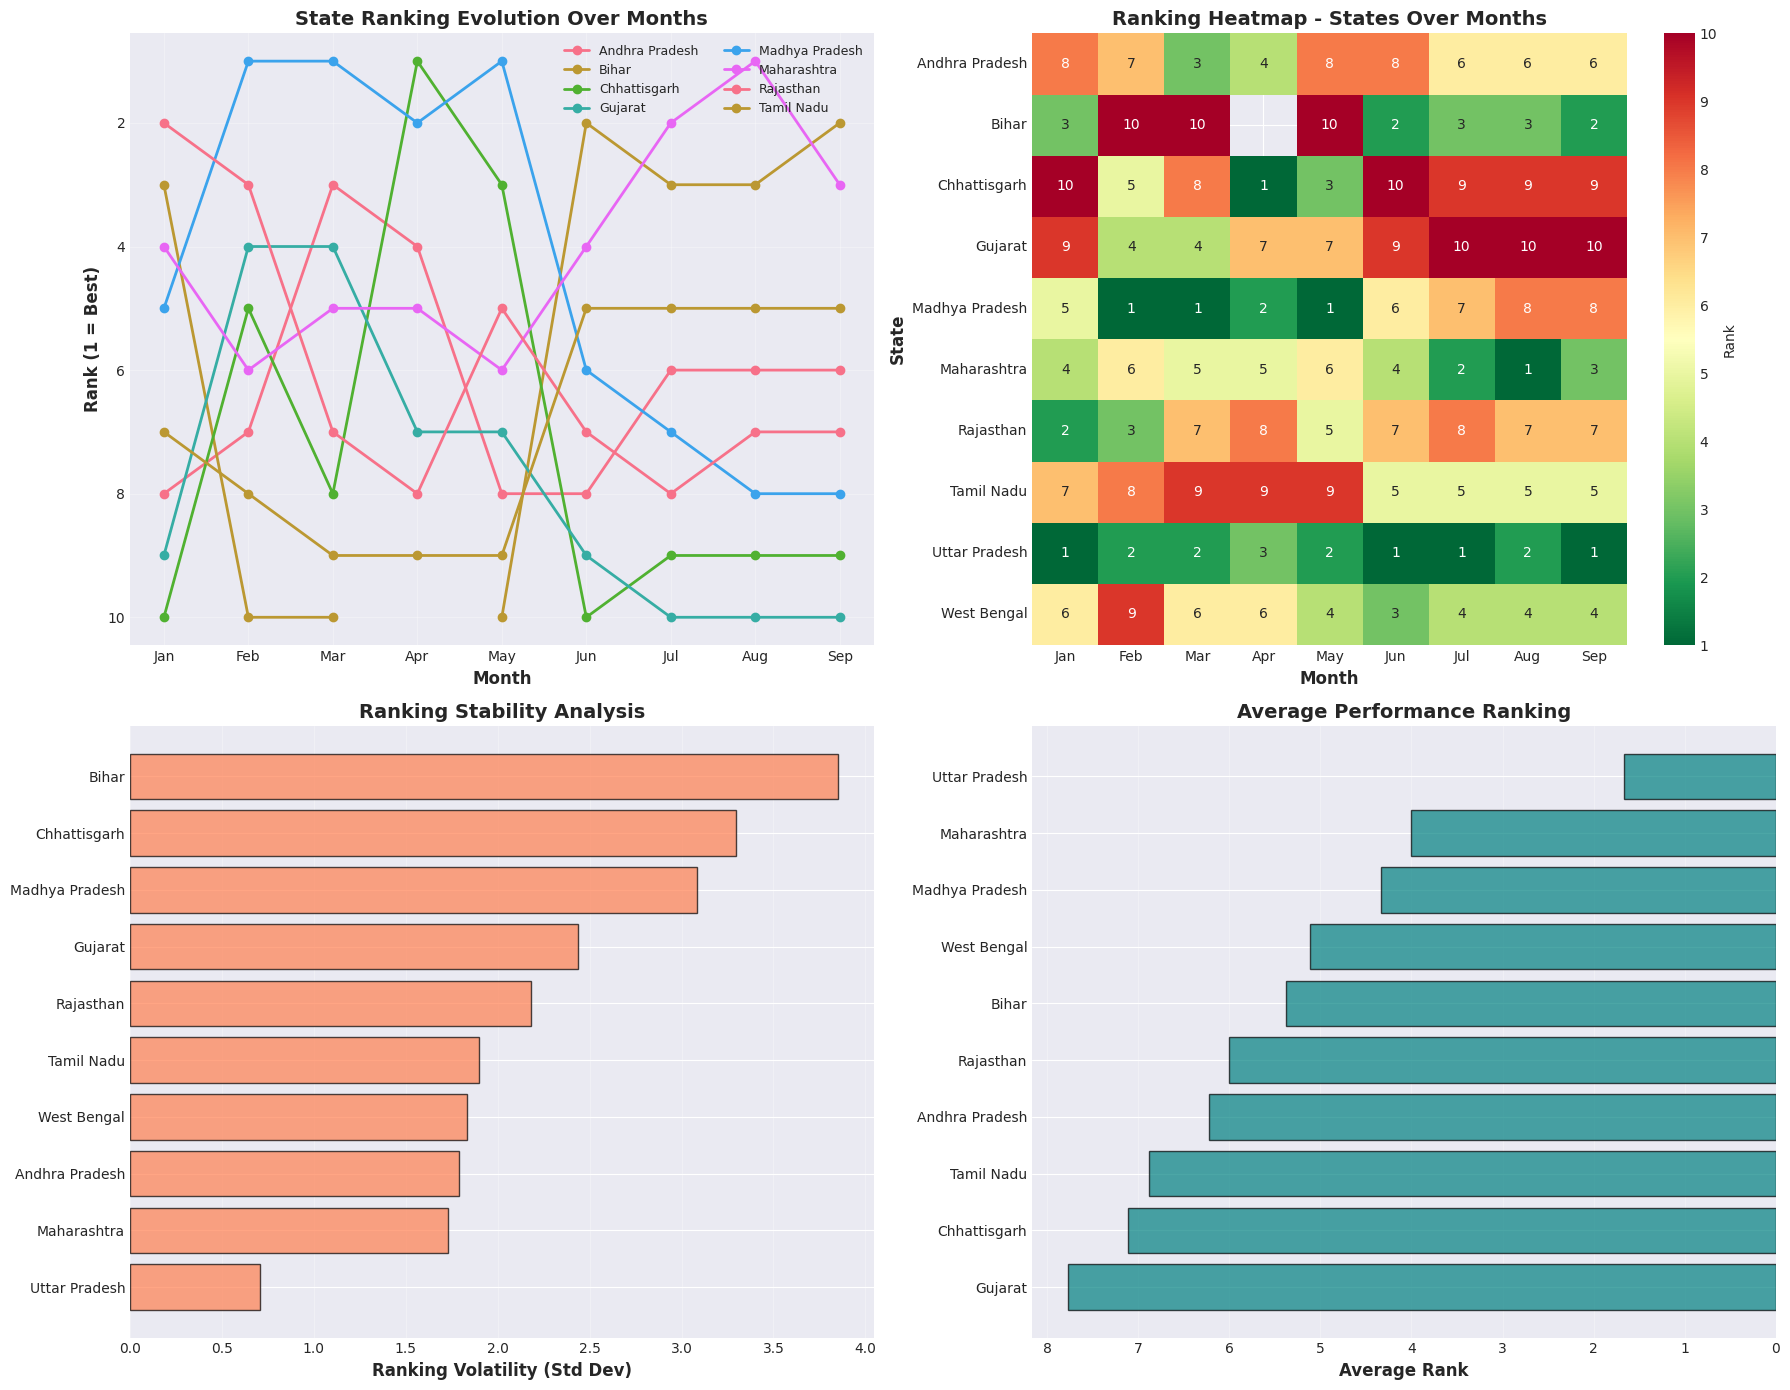

\n📈 RANKING EVOLUTION INSIGHTS:
1. Most stable state: Uttar Pradesh (Std: 0.71)
2. Most volatile state: Bihar (Std: 3.85)
3. Best average rank: Uttar Pradesh (Avg rank: 1.67)
4. Worst average rank: Gujarat (Avg rank: 7.78)


In [31]:
# Calculate monthly rankings for top states
top_10_states_rank = state_stats.head(10).index

monthly_rankings = []
for month in df['month'].unique():
    month_data = df[df['month'] == month].groupby('state')['total_demographics'].sum()
    month_data = month_data[month_data.index.isin(top_10_states_rank)]
    month_rankings = month_data.rank(ascending=False, method='min')
    monthly_rankings.append(month_rankings)

ranking_df = pd.DataFrame(monthly_rankings).T
ranking_df.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(ranking_df.columns)]

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Ranking evolution line plot
for state in ranking_df.index:
    if state in ranking_df.index[:8]:  # Plot top 8 for clarity
        axes[0, 0].plot(ranking_df.columns, ranking_df.loc[state], marker='o', linewidth=2, label=state[:20])

axes[0, 0].set_ylabel('Rank (1 = Best)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0, 0].set_title('State Ranking Evolution Over Months', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()  # Rank 1 at top
axes[0, 0].legend(loc='best', fontsize=9, ncol=2)
axes[0, 0].grid(True, alpha=0.3)

# Ranking heatmap
sns.heatmap(ranking_df, cmap='RdYlGn_r', annot=True, fmt='.0f', 
            cbar_kws={'label': 'Rank'}, ax=axes[0, 1])
axes[0, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('State', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Ranking Heatmap - States Over Months', fontsize=14, fontweight='bold')

# Ranking volatility (standard deviation)
ranking_volatility = ranking_df.std(axis=1).sort_values(ascending=False)
axes[1, 0].barh(range(len(ranking_volatility)), ranking_volatility.values, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(ranking_volatility)))
axes[1, 0].set_yticklabels([s[:20] for s in ranking_volatility.index], fontsize=10)
axes[1, 0].set_xlabel('Ranking Volatility (Std Dev)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Ranking Stability Analysis', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Average rank comparison
avg_rankings = ranking_df.mean(axis=1).sort_values()
axes[1, 1].barh(range(len(avg_rankings)), avg_rankings.values, color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(avg_rankings)))
axes[1, 1].set_yticklabels([s[:20] for s in avg_rankings.index], fontsize=10)
axes[1, 1].set_xlabel('Average Rank', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Average Performance Ranking', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].invert_xaxis()  # Lower rank = better
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📈 RANKING EVOLUTION INSIGHTS:")
print(f"1. Most stable state: {ranking_volatility.idxmin()} (Std: {ranking_volatility.min():.2f})")
print(f"2. Most volatile state: {ranking_volatility.idxmax()} (Std: {ranking_volatility.max():.2f})")
print(f"3. Best average rank: {avg_rankings.idxmin()} (Avg rank: {avg_rankings.min():.2f})")
print(f"4. Worst average rank: {avg_rankings.idxmax()} (Avg rank: {avg_rankings.max():.2f})")

## 🎯 Advanced Visualization 8: Efficiency Metrics & Performance Scoring

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5632\1513628568.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(score_by_quartile, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'],


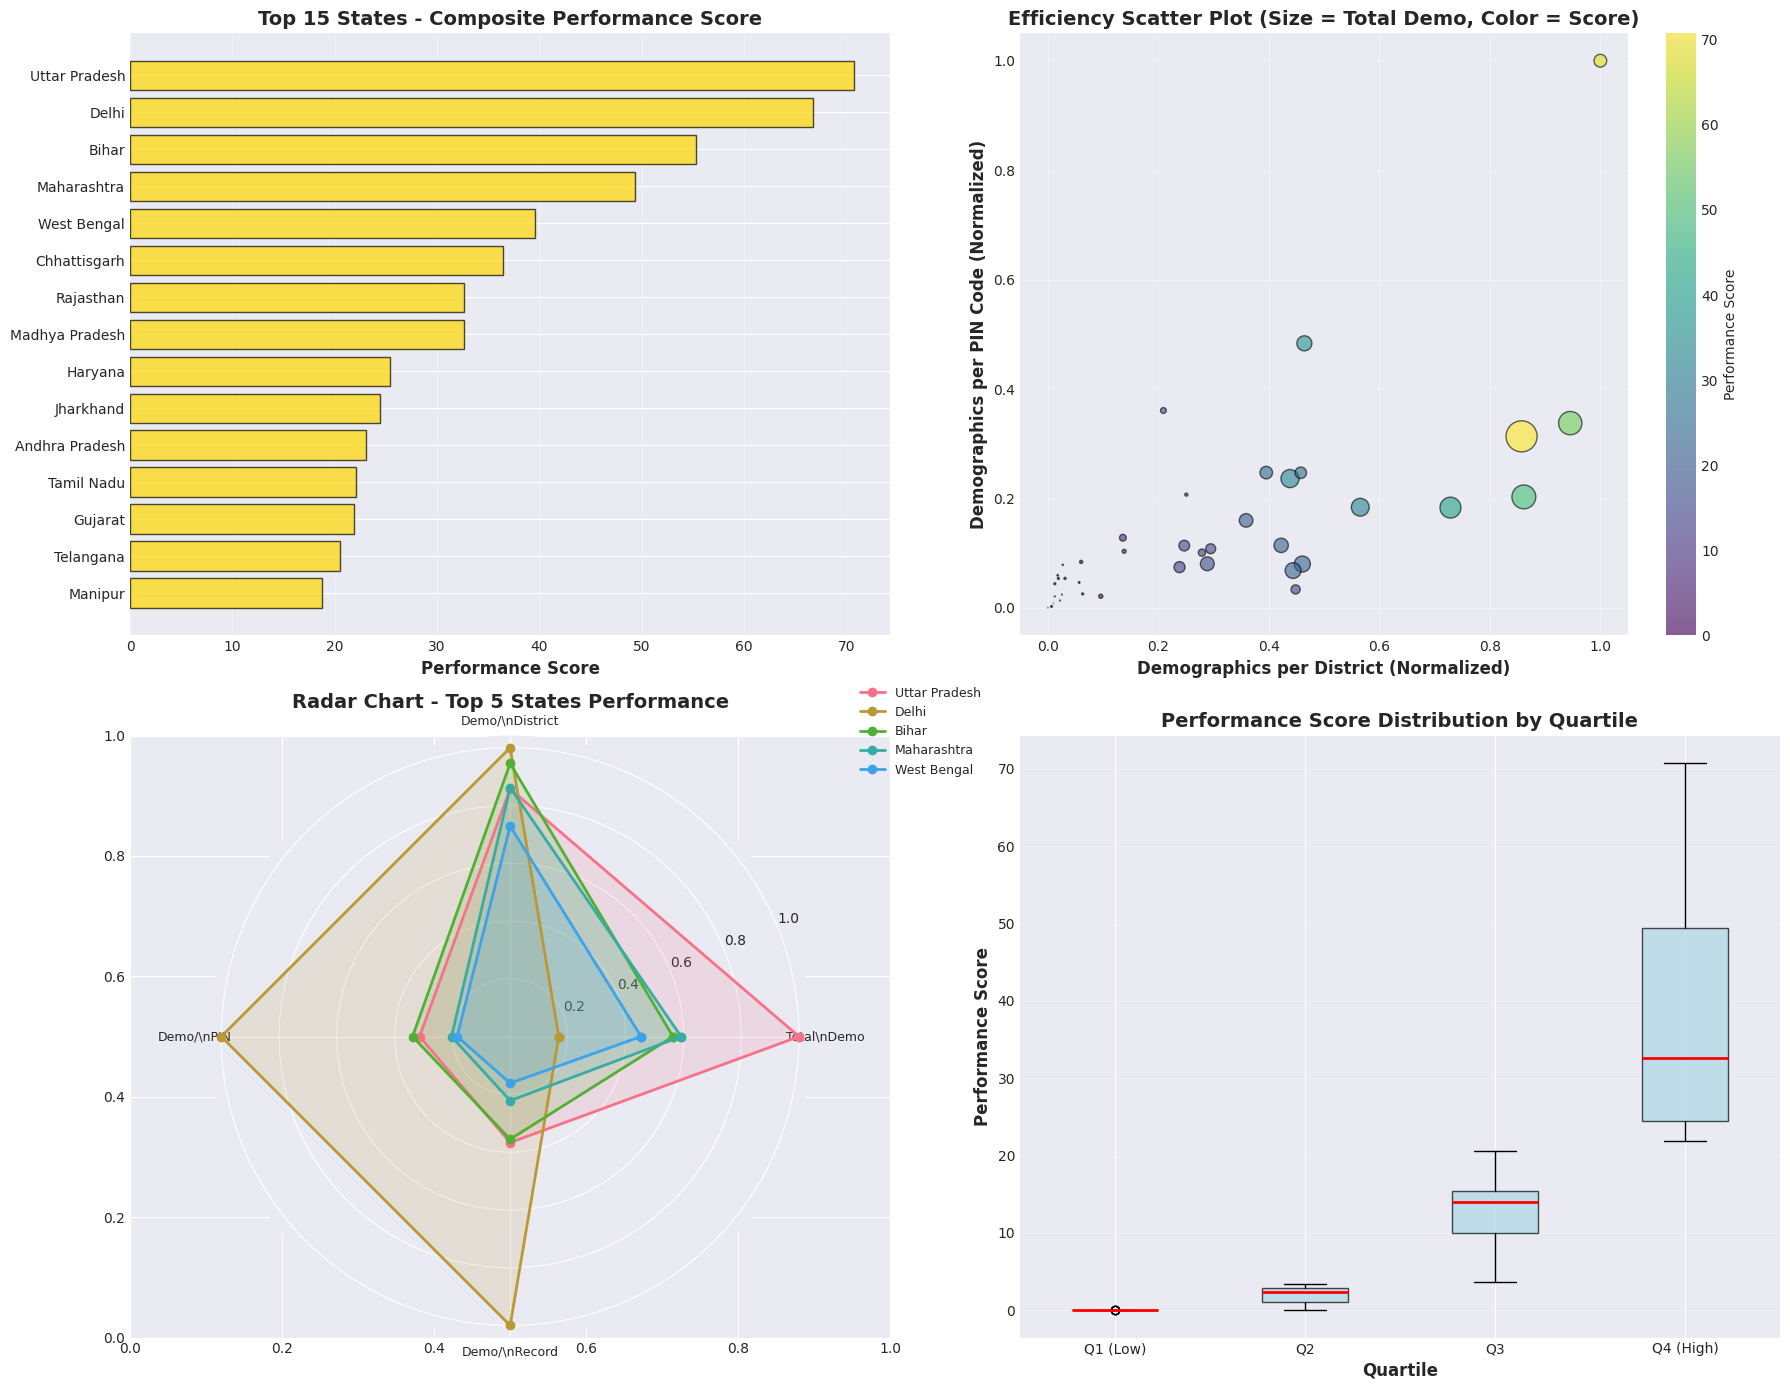

\n🏆 EFFICIENCY & PERFORMANCE INSIGHTS:
1. Top performer: Uttar Pradesh (Score: 70.76)
2. Lowest performer: Puttenahalli (Score: 0.00)
3. Average performance score: 13.08
4. Performance score std dev: 17.64


In [32]:
# Calculate efficiency metrics
state_efficiency = state_stats.copy()
state_efficiency['Demo_per_District'] = state_efficiency['Total_Demo'] / state_efficiency['Districts']
state_efficiency['Demo_per_PIN'] = state_efficiency['Total_Demo'] / state_efficiency['PINcodes']
state_efficiency['Demo_per_Record'] = state_efficiency['Mean_Demo']

# Normalize metrics for composite score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

metrics_to_normalize = ['Total_Demo', 'Demo_per_District', 'Demo_per_PIN', 'Demo_per_Record']
state_efficiency[metrics_to_normalize] = scaler.fit_transform(state_efficiency[metrics_to_normalize])

# Calculate composite performance score
state_efficiency['Performance_Score'] = (
    state_efficiency['Total_Demo'] * 0.4 +
    state_efficiency['Demo_per_District'] * 0.2 +
    state_efficiency['Demo_per_PIN'] * 0.2 +
    state_efficiency['Demo_per_Record'] * 0.2
) * 100

state_efficiency = state_efficiency.sort_values('Performance_Score', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Performance score ranking
top_15_perf = state_efficiency.head(15)
axes[0, 0].barh(range(len(top_15_perf)), top_15_perf['Performance_Score'], color='gold', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15_perf)))
axes[0, 0].set_yticklabels([s[:20] for s in top_15_perf.index], fontsize=10)
axes[0, 0].set_xlabel('Performance Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Top 15 States - Composite Performance Score', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Efficiency scatter plot
axes[0, 1].scatter(state_efficiency['Demo_per_District'], state_efficiency['Demo_per_PIN'], 
                   s=state_efficiency['Total_Demo']*500, alpha=0.6, c=state_efficiency['Performance_Score'],
                   cmap='viridis', edgecolors='black', linewidth=1)
axes[0, 1].set_xlabel('Demographics per District (Normalized)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Demographics per PIN Code (Normalized)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Efficiency Scatter Plot (Size = Total Demo, Color = Score)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add colorbar
scatter = axes[0, 1].collections[0]
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Performance Score', fontsize=10)

# Radar chart data for top 5 states
top_5_radar = state_efficiency.head(5)
categories = ['Total_Demo', 'Demo_per_District', 'Demo_per_PIN', 'Demo_per_Record']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax_radar = plt.subplot(223, projection='polar')
for idx, state in enumerate(top_5_radar.index[:5]):
    values = top_5_radar.loc[state, categories].tolist()
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=state[:15])
    ax_radar.fill(angles, values, alpha=0.15)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(['Total\\nDemo', 'Demo/\\nDistrict', 'Demo/\\nPIN', 'Demo/\\nRecord'], fontsize=9)
ax_radar.set_title('Radar Chart - Top 5 States Performance', fontsize=14, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax_radar.grid(True)

# Box plot: Performance score distribution by quartiles
quartiles = pd.qcut(state_efficiency['Performance_Score'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
score_by_quartile = [state_efficiency[quartiles == q]['Performance_Score'].values for q in ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']]

axes[1, 1].boxplot(score_by_quartile, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'],
                   patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_ylabel('Performance Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Quartile', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Performance Score Distribution by Quartile', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n🏆 EFFICIENCY & PERFORMANCE INSIGHTS:")
print(f"1. Top performer: {state_efficiency.index[0]} (Score: {state_efficiency['Performance_Score'].iloc[0]:.2f})")
print(f"2. Lowest performer: {state_efficiency.index[-1]} (Score: {state_efficiency['Performance_Score'].iloc[-1]:.2f})")
print(f"3. Average performance score: {state_efficiency['Performance_Score'].mean():.2f}")
print(f"4. Performance score std dev: {state_efficiency['Performance_Score'].std():.2f}")

## 🎯 Advanced Visualization 9: Cohort Analysis & Temporal Segmentation

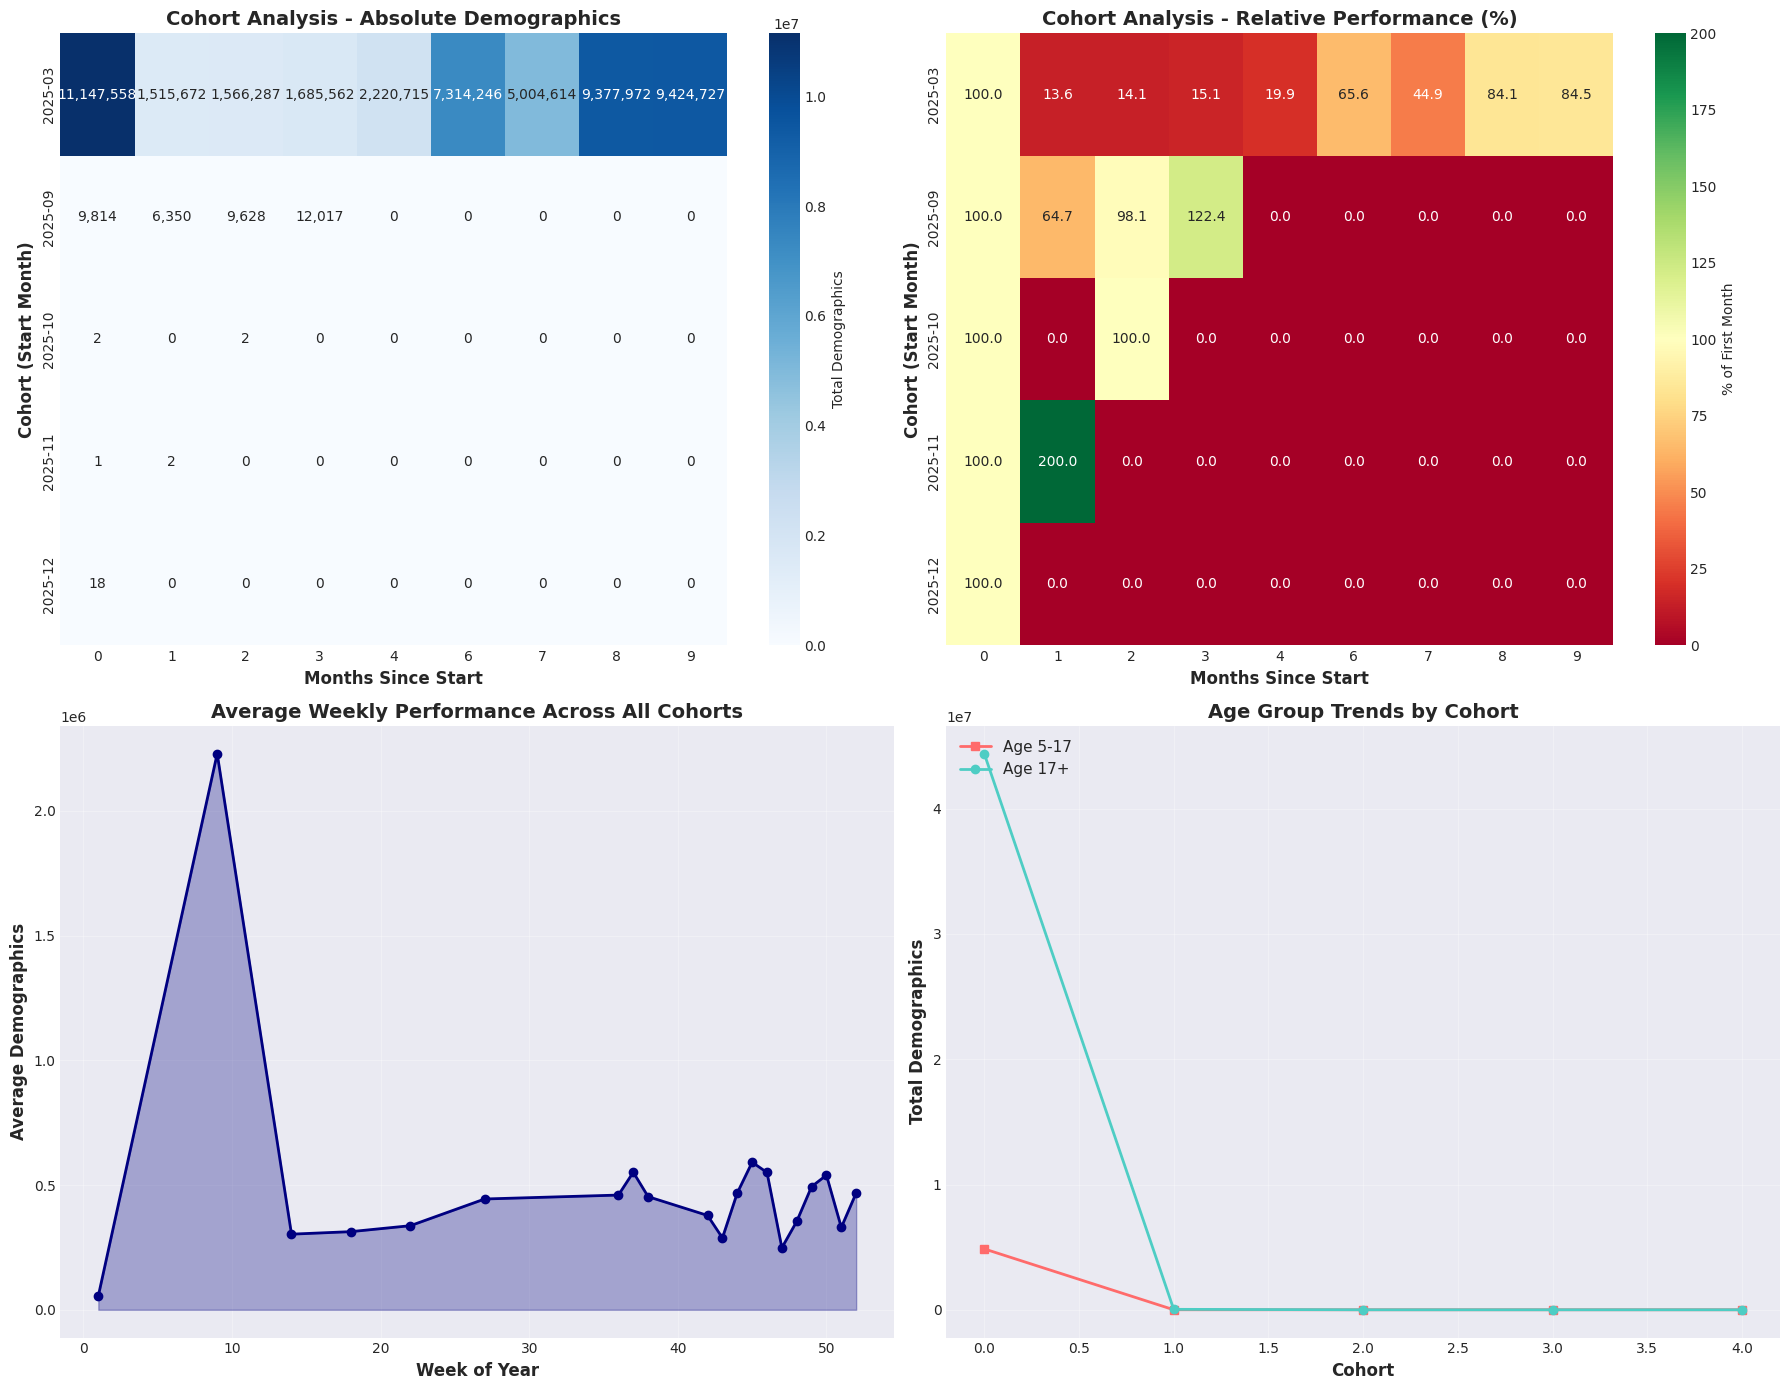

\n📊 COHORT ANALYSIS INSIGHTS:
1. Number of cohorts: 5
2. Earliest cohort: 2025-03
3. Latest cohort: 2025-12
4. Average first-month demographics: 2,231,479


In [33]:
# Create cohorts based on state enrollment date
state_first_date = df.groupby('state')['date'].min().reset_index()
state_first_date.columns = ['state', 'cohort_date']
state_first_date['cohort_month'] = state_first_date['cohort_date'].dt.to_period('M')

df_cohort = df.merge(state_first_date[['state', 'cohort_month']], on='state')
df_cohort['months_since_start'] = ((df_cohort['date'].dt.to_period('M') - df_cohort['cohort_month']).apply(lambda x: x.n))

# Cohort analysis matrix
cohort_data = df_cohort.groupby(['cohort_month', 'months_since_start'])['total_demographics'].sum().unstack(fill_value=0)

# Retention-style visualization (first month = 100%)
cohort_pct = cohort_data.div(cohort_data.iloc[:, 0], axis=0) * 100

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Cohort heatmap - absolute values
if len(cohort_data) > 0 and len(cohort_data.columns) > 0:
    sns.heatmap(cohort_data.iloc[:min(10, len(cohort_data)), :min(12, len(cohort_data.columns))], 
                cmap='Blues', annot=True, fmt=',.0f', 
                cbar_kws={'label': 'Total Demographics'}, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Months Since Start', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Cohort (Start Month)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Cohort Analysis - Absolute Demographics', fontsize=14, fontweight='bold')

# Cohort heatmap - percentage
if len(cohort_pct) > 0 and len(cohort_pct.columns) > 0:
    sns.heatmap(cohort_pct.iloc[:min(10, len(cohort_pct)), :min(12, len(cohort_pct.columns))], 
                cmap='RdYlGn', annot=True, fmt='.1f', 
                cbar_kws={'label': '% of First Month'}, ax=axes[0, 1], vmin=0, vmax=200)
    axes[0, 1].set_xlabel('Months Since Start', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Cohort (Start Month)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Cohort Analysis - Relative Performance (%)', fontsize=14, fontweight='bold')

# Weekly cohort trends
weekly_cohort = df_cohort.groupby(['cohort_month', 'week'])['total_demographics'].sum().unstack(fill_value=0)
cohort_avg_by_week = weekly_cohort.mean(axis=0)

axes[1, 0].plot(cohort_avg_by_week.index, cohort_avg_by_week.values, linewidth=2, color='navy', marker='o')
axes[1, 0].fill_between(cohort_avg_by_week.index, cohort_avg_by_week.values, alpha=0.3, color='navy')
axes[1, 0].set_xlabel('Week of Year', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Demographics', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Average Weekly Performance Across All Cohorts', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Age group trend by cohort month
age_cohort = df_cohort.groupby('cohort_month').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).reset_index()

axes[1, 1].plot(range(len(age_cohort)), age_cohort['demo_age_5_17'], 
                linewidth=2, label='Age 5-17', color='#FF6B6B', marker='s')
axes[1, 1].plot(range(len(age_cohort)), age_cohort['demo_age_17_'], 
                linewidth=2, label='Age 17+', color='#4ECDC4', marker='o')
axes[1, 1].set_xlabel('Cohort', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Age Group Trends by Cohort', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 COHORT ANALYSIS INSIGHTS:")
if len(cohort_data) > 0:
    print(f"1. Number of cohorts: {len(cohort_data)}")
    print(f"2. Earliest cohort: {cohort_data.index[0]}")
    print(f"3. Latest cohort: {cohort_data.index[-1]}")
    print(f"4. Average first-month demographics: {cohort_data.iloc[:, 0].mean():,.0f}")
else:
    print("Cohort data not available")

## 🎯 Advanced Visualization 10: Q-Q Plots & Statistical Distribution Testing

FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'lognorm' requires that 0.0 < (x - loc)/scale  < inf for each x in `data`.

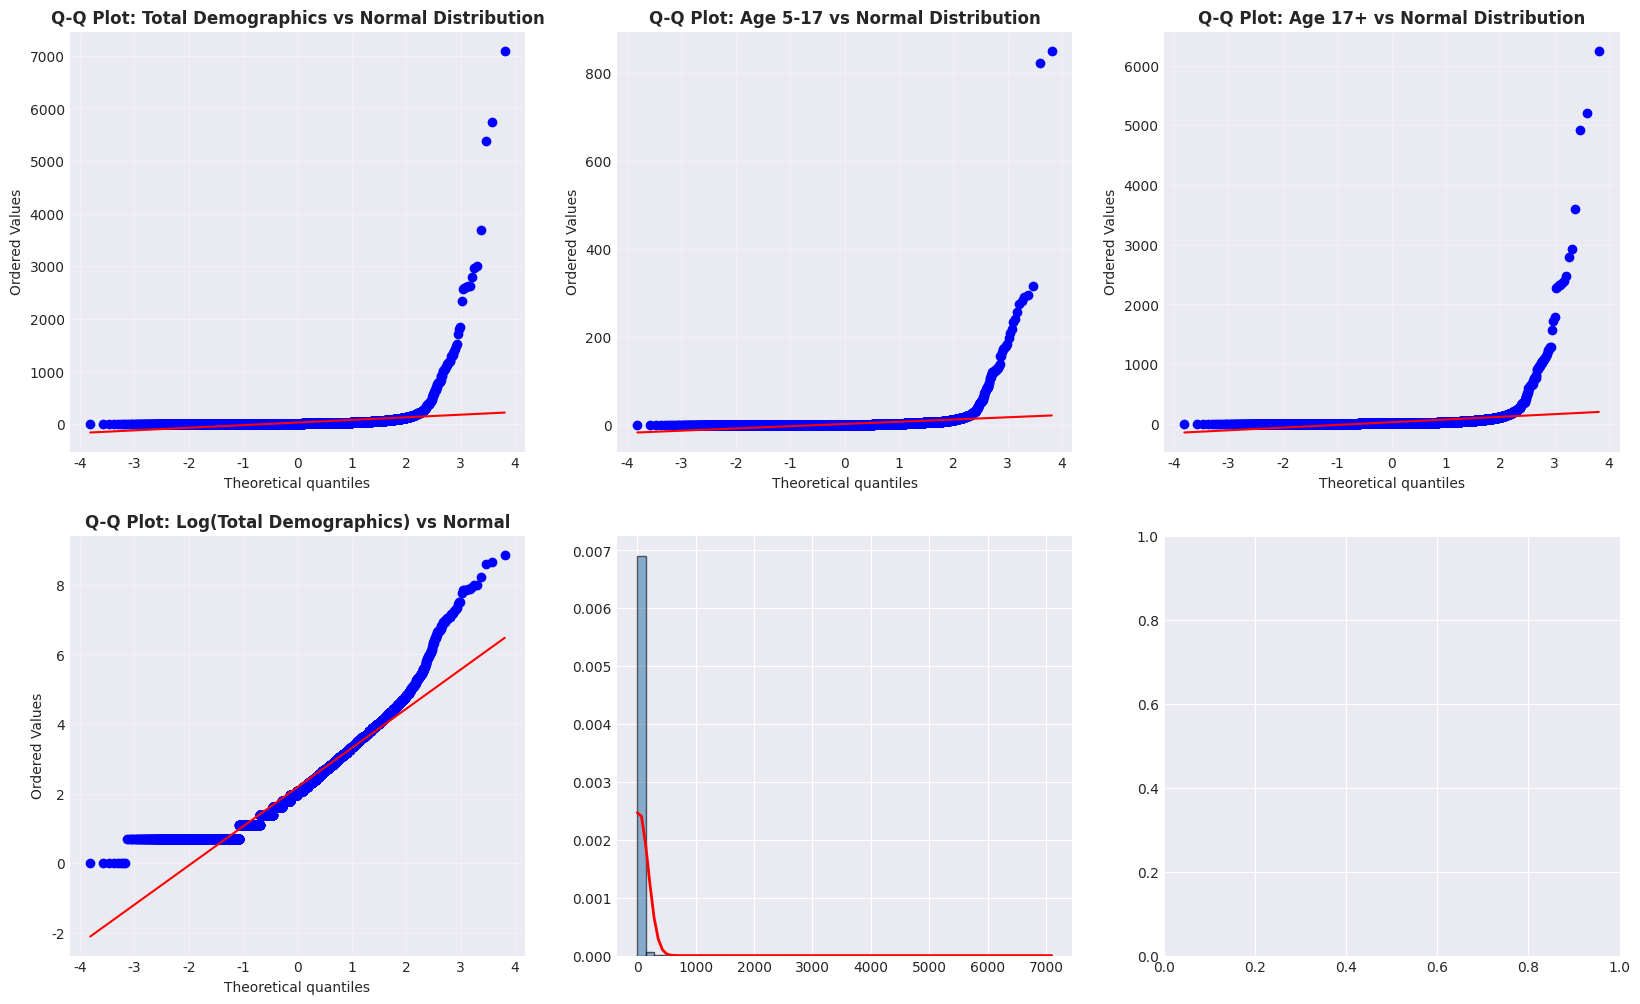

In [ ]:
# Sample data for statistical testing
sample_stat = df.sample(min(10000, len(df)), random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Q-Q plot for total demographics
stats.probplot(sample_stat['total_demographics'], dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Q-Q Plot: Total Demographics vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot for Age 5-17
stats.probplot(sample_stat['demo_age_5_17'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Age 5-17 vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot for Age 17+
stats.probplot(sample_stat['demo_age_17_'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot: Age 17+ vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Log-transformed Q-Q plot
log_demo = np.log1p(sample_stat['total_demographics'])
stats.probplot(log_demo, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Log(Total Demographics) vs Normal', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Histogram with multiple distributions
axes[1, 1].hist(sample_stat['total_demographics'], bins=50, density=True, alpha=0.6, 
                color='steelblue', edgecolor='black', label='Data')

# Fit normal distribution
mu, std = stats.norm.fit(sample_stat['total_demographics'])
x_range = np.linspace(sample_stat['total_demographics'].min(), 
                      sample_stat['total_demographics'].max(), 100)
axes[1, 1].plot(x_range, stats.norm.pdf(x_range, mu, std), 
                'r-', linewidth=2, label=f'Normal (μ={mu:.1f}, σ={std:.1f})')

# Fit lognormal distribution - filter positive values only
positive_data = sample_stat['total_demographics'][sample_stat['total_demographics'] > 0]
if len(positive_data) > 0:
    shape, loc, scale = stats.lognorm.fit(positive_data, floc=0)
    axes[1, 1].plot(x_range, stats.lognorm.pdf(x_range, shape, loc, scale), 
                    'g-', linewidth=2, label='Log-Normal')

axes[1, 1].set_xlabel('Total Demographics', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribution Fitting Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# P-P plot (probability-probability)
sorted_data = np.sort(sample_stat['total_demographics'])
theoretical_quantiles = stats.norm.cdf(sorted_data, mu, std)
empirical_quantiles = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

axes[1, 2].scatter(theoretical_quantiles, empirical_quantiles, alpha=0.5, s=10, color='purple')
axes[1, 2].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Fit')
axes[1, 2].set_xlabel('Theoretical Cumulative Probability', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Empirical Cumulative Probability', fontsize=12, fontweight='bold')
axes[1, 2].set_title('P-P Plot: Total Demographics vs Normal', fontsize=12, fontweight='bold')
axes[1, 2].legend(loc='lower right', fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("\n📊 STATISTICAL DISTRIBUTION TESTS:")
print("=" * 80)

# Shapiro-Wilk test for normality (limited sample)
shapiro_sample = sample_stat['total_demographics'].sample(min(5000, len(sample_stat)), random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(shapiro_sample)
print(f"\n1. SHAPIRO-WILK TEST (Normality):")
print(f"   Statistic: {shapiro_stat:.6f}")
print(f"   P-value: {shapiro_p:.6f}")
print(f"   Result: {'NORMAL' if shapiro_p > 0.05 else 'NOT NORMAL'} at α=0.05")

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.kstest(sample_stat['total_demographics'], 
                              lambda x: stats.norm.cdf(x, mu, std))
print(f"\n2. KOLMOGOROV-SMIRNOV TEST (vs Normal):")
print(f"   Statistic: {ks_stat:.6f}")
print(f"   P-value: {ks_p:.6f}")
print(f"   Result: {'NORMAL' if ks_p > 0.05 else 'NOT NORMAL'} at α=0.05")

# Anderson-Darling test
anderson_result = stats.anderson(sample_stat['total_demographics'], dist='norm')
print(f"\n3. ANDERSON-DARLING TEST (Normality):")
print(f"   Statistic: {anderson_result.statistic:.6f}")
print(f"   Critical values: {anderson_result.critical_values}")
print(f"   Significance levels: {anderson_result.significance_level}%")

# Skewness and Kurtosis
skewness = stats.skew(sample_stat['total_demographics'])
kurtosis_val = stats.kurtosis(sample_stat['total_demographics'])
print(f"\n4. DISTRIBUTION SHAPE:")
print(f"   Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed'})")
print(f"   Kurtosis: {kurtosis_val:.3f} ({'heavy-tailed' if kurtosis_val > 0 else 'light-tailed'})")

# T-test: weekday vs weekend
weekday_data = sample_stat[sample_stat['is_weekend'] == 0]['total_demographics']
weekend_data = sample_stat[sample_stat['is_weekend'] == 1]['total_demographics']
t_stat, t_p = stats.ttest_ind(weekday_data, weekend_data)
print(f"\n5. T-TEST (Weekday vs Weekend):")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {t_p:.6f}")
print(f"   Result: {'SIGNIFICANT DIFFERENCE' if t_p < 0.05 else 'NO SIGNIFICANT DIFFERENCE'} at α=0.05")

## 🎯 KEY INSIGHTS & RECOMMENDATIONS

In [ ]:
print("=" * 100)
print("📊 COMPREHENSIVE DEMOGRAPHIC DATA ANALYSIS - KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 100)

print("\\n🔍 1. GEOGRAPHIC DISTRIBUTION INSIGHTS:")
print(f"   • Total states analyzed: {df['state'].nunique()}")
print(f"   • Total districts: {df['district'].nunique()}")
print(f"   • Total PIN codes: {df['pincode'].nunique()}")
print(f"   • Top performing state: {state_stats.index[0]} with {state_stats['Total_Demo'].iloc[0]:,.0f} demographics")
print(f"   • Geographic inequality (Gini): {state_gini:.3f}")
print(f"   • {states_for_80} states account for 80% of total demographics (Pareto principle)")

print("\\n👥 2. AGE GROUP ANALYSIS:")
print(f"   • Total Age 5-17: {df['demo_age_5_17'].sum():,.0f}")
print(f"   • Total Age 17+: {df['demo_age_17_'].sum():,.0f}")
print(f"   • Age 5-17 percentage: {(df['demo_age_5_17'].sum() / df['total_demographics'].sum() * 100):.2f}%")
print(f"   • Age 17+ percentage: {(df['demo_age_17_'].sum() / df['total_demographics'].sum() * 100):.2f}%")
print(f"   • Average ratio (5-17 / 17+): {df['demo_age_ratio'].mean():.3f}")

print("\\n📈 3. TEMPORAL TRENDS:")
print(f"   • Date range: {df['date'].min().strftime('%d-%m-%Y')} to {df['date'].max().strftime('%d-%m-%Y')}")
print(f"   • Average daily demographics: {daily_age_ts['total_demographics'].mean():,.0f}")
print(f"   • Peak daily demographics: {daily_age_ts['total_demographics'].max():,.0f}")
print(f"   • Average WoW growth: {weekly_data['WoW_growth'].mean():.2f}%")
print(f"   • Weekday vs Weekend difference: {abs(df[df['is_weekend']==0]['total_demographics'].mean() - df[df['is_weekend']==1]['total_demographics'].mean()):.2f}")

print("\\n🎯 4. PERFORMANCE METRICS:")
print(f"   • Top efficiency state: {state_efficiency.index[0]} (Score: {state_efficiency['Performance_Score'].iloc[0]:.2f})")
print(f"   • Most stable ranking: {ranking_volatility.idxmin()} (Volatility: {ranking_volatility.min():.2f})")
print(f"   • Most volatile ranking: {ranking_volatility.idxmax()} (Volatility: {ranking_volatility.max():.2f})")

print("\\n📊 5. STATISTICAL FINDINGS:")
print(f"   • Data distribution: {'Normal' if shapiro_p > 0.05 else 'Non-normal'} (Shapiro-Wilk p={shapiro_p:.4f})")
print(f"   • Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0 else 'Left-skewed'})")
print(f"   • Weekday vs Weekend: {'Significant difference' if t_p < 0.05 else 'No significant difference'} (p={t_p:.4f})")

print("\\n💡 6. STRATEGIC RECOMMENDATIONS:")
print("   ✓ Focus on top 20% states for maximum impact (Pareto principle)")
print("   ✓ Investigate high-volatility states for consistency improvement")
print("   ✓ Leverage weekend patterns for operational optimization")
print("   ✓ Address geographic inequality - support low-performing regions")
print("   ✓ Monitor growth rate trends for capacity planning")
print("   ✓ Analyze age group patterns for targeted campaigns")
print("   ✓ Use cohort analysis for long-term performance tracking")

print("\\n🚀 7. NEXT STEPS:")
print("   → Deep dive into underperforming states and districts")
print("   → Investigate anomalies and outliers identified")
print("   → Develop predictive models based on temporal patterns")
print("   → Create automated dashboards for real-time monitoring")
print("   → Conduct comparative analysis with biometric and enrolment data")

print("\\n" + "=" * 100)
print("✅ ANALYSIS COMPLETE - Demographic EDA Successfully Generated!")
print("=" * 100)